- `pdockq` hardly correlates with our binary labels, nor with hu.MAP values
 - in particular in our set: confident predictions are usually PPIs
- `pdockq`: us *vs* them
- confident predictions are more frequent for ordered pairs
- both are more frequent in hu.MAP than in HuRI


In [1]:
from pathlib import Path

import json

import pandas as pd
import numpy as np

In [2]:
from ppi_utils.reduce import dedup_pairs
from ppi_utils.pairs import estimate_bias, estimate_bias_per_species
from ppi_utils.api import uniprot_api_fetch
from ppi_utils.extract import ppis_to_hashes
from ppi_utils.general import get_seq_hash, get_ids

## Extract PPIs from the original hu.MAP 2.0

In [3]:
humap_dir = Path.cwd().parent / 'ppi_data/hu.MAP'
assert humap_dir.is_dir()
humap_dir

PosixPath('/home/quirin/PYTHON/ppi/ppi_data/hu.MAP')

There is a train-test-split already!?

In [4]:
humap = list()
for txt in sorted(humap_dir.glob('*.txt')):
    if 'complexes' in txt.stem:
        continue
    tx = pd.read_csv(txt, sep='\t', header=None, names=['ida', 'idb'])
    tx['label'] = 0 if 'neg' in txt.stem else 1
    tx['set_type'] = 'train' if 'train' in txt.stem else 'test'
    humap.append(tx)
humap = pd.concat(humap)

In [5]:
humap.head()

,ida,idb,label,set_type
0,Q99966,Q13393,0,test
1,P78352,Q15648,0,test
2,P42345,Q6WN34,0,test
3,P03891,Q9H0D2,0,test
4,Q9UJY1,Q9H0D2,0,test


In [6]:
h = dedup_pairs(humap.copy())
len(humap), len(humap) - len(h), 'That\'s huuuuuge!'

(3435064, 1417, "That's huuuuuge!")

In [7]:
humap = h
humap.head()

,ida,idb,label,set_type
0,Q13393,Q99966,0,test
1,P78352,Q15648,0,test
2,P42345,Q6WN34,0,test
3,P03891,Q9H0D2,0,test
4,Q9H0D2,Q9UJY1,0,test


In [8]:
humap.set_type.value_counts()
# train-test-split of roughly equal size?!

test     1798599
train    1635048
Name: set_type, dtype: int64

In [9]:
all_ids = dict()
for t in ['train', 'test']:
    h = humap.loc[humap.set_type == t]
    bias = estimate_bias(h)
    ids = set(h.ida) | set(h.idb)
    all_ids[t] = ids
    print(f'{t}:\tn_pairs = {len(h)}\tn_PPIs = {len(h.loc[h.label == 1])}\tbias = {bias[0]:.3f}\tn_uniprot_ids = {len(ids)}')
print(f'shared IDs: {len(all_ids["train"] & all_ids["test"])}')
'Mostly negatives - that\'s kind of good to see'

train:	n_pairs = 1635048	n_PPIs = 7172	bias = -0.228	n_uniprot_ids = 1937
test:	n_pairs = 1798599	n_PPIs = 8329	bias = -0.183	n_uniprot_ids = 2023
shared IDs: 968


"Mostly negatives - that's kind of good to see"

In [10]:
humap.loc[(humap.set_type == 'train')].label.value_counts()

0    1627876
1       7172
Name: label, dtype: int64

In [11]:
uniprot_ids = sorted(all_ids['train'] | all_ids['test'])
len(uniprot_ids), uniprot_ids[:7],

(2992, ['10207', '280964', '3507', '403846', '84311', 'A0AVF1', 'A0JLT2'])

In [12]:
uniprot_ids = [_id for _id in uniprot_ids if not _id.isnumeric()]
len(uniprot_ids), uniprot_ids[:4],

(2987, ['A0AVF1', 'A0JLT2', 'A1A4S6', 'A2A288'])

### Fetch UniProt sequences

In [ ]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/humap.fasta'))

In [ ]:
res

In [13]:
hash_humap = ppis_to_hashes(humap, Path('uniprot/humap.json'))
hash_humap.head()

,hash_A,hash_B,label,set_type
378407,CRC-000037AE195F7A9D,CRC-0008E21D66E8CFEC,0,test
74220,CRC-000037AE195F7A9D,CRC-000F380D23A9FE8F,0,train
610541,CRC-000037AE195F7A9D,CRC-0026F07D7AB33295,0,test
1084683,CRC-000037AE195F7A9D,CRC-003B3F654F0C60DF,0,test
1772333,CRC-000037AE195F7A9D,CRC-003FABF28F5405D0,0,test


In [14]:
hppis = hash_humap.loc[hash_humap.label == 1]
len(hppis)

15501

In [15]:
hppis.head()

,hash_A,hash_B,label,set_type
1378,CRC-000037AE195F7A9D,CRC-0249E6CA12F77934,1,test
7387,CRC-000037AE195F7A9D,CRC-0860CECC8BF674FE,1,test
1646,CRC-000037AE195F7A9D,CRC-1A73DD35A3501861,1,test
4761,CRC-000037AE195F7A9D,CRC-2023CA8590C7752C,1,train
3868,CRC-000037AE195F7A9D,CRC-26EC965C9239774E,1,test


In [16]:
len(hppis.loc[hppis.set_type == 'train'])

7172

In [17]:
len(hppis.loc[hppis.set_type == 'test'])

8329

In [18]:
ppis = humap.loc[humap.label == 1]
len(ppis)

15501

In [19]:
ppis.head()

,ida,idb,label,set_type
0,Q13616,Q9Y297,1,test
1,O15111,Q676U5,1,test
2,P06213,P35568,1,test
3,P11802,P24385,1,test
4,O00472,Q9HB65,1,test


In [20]:
len(ppis), len(hppis)

(15501, 15501)

### Don't need the hashing!

In [21]:
del hash_humap
del hppis

In [22]:
# look at an example
_id = 'P11802'
ppis.loc[(ppis.ida == _id) | (ppis.idb == _id)]

,ida,idb,label,set_type
3,P11802,P24385,1,test
537,P11802,P30279,1,test
3396,P11802,P38936,1,test
3908,P11802,P30281,1,test
4790,P11802,Q00534,1,test
1068,P11802,P12004,1,train


In [23]:
ppis.loc[ppis.ida == ppis.idb]
# There's a homodimer!

,ida,idb,label,set_type
3260,P0DMV9,P0DMV9,1,train


## Compare to the hu.MAP set as used by [Burke et al.](https://doi.org/10.1038/s41594-022-00910-8) on their [git](https://gitlab.com/ElofssonLab/huintaf2)

In [24]:
huintaf_dir = Path('/home/quirin/PYTHON/huintaf2')
huintaf = pd.read_csv(huintaf_dir / 'data/humap_pairs.txt', sep=' ', header=None, names=['ida', 'idb'])
len(huintaf)

57128

In [25]:
huintaf.head()

,ida,idb
0,A0A0B4J2A2,A0A075B759
1,A6NI28,A1A4S6
2,A6NJ78,A6NFY7
3,A8MZ97,A6NKD9
4,C9J7I0,A5D8V6


In [26]:
# also no duplicates there
assert len(dedup_pairs(huintaf)) == len(huintaf)

In [27]:
huintaf.loc[(huintaf.ida == _id) | (huintaf.idb == _id)]
# are these predictions? Cause it's sure as heck not the same stuff ...

,ida,idb
4641,P42772,P11802
4643,P42773,P11802
6591,P55273,P11802
10272,Q00534,P11802
16377,Q5TC84,P11802
22713,Q8N726,P11802


## Re-try from OG hu.MAP
Burke et al say they selected the hu.MAP PPIs with a score `> .5`

In [113]:
wumap = pd.read_csv(humap_dir / 'humap2_ppis_ACC_20200821.pairsWprob',
                    sep='\t', header=None, names=['ida', 'idb', 'prob'])
len(wumap)

17526311

In [114]:
wumap.head()

,ida,idb,prob
0,P46926,Q8TDQ7,1.0
1,P43631,Q14954,1.0
2,P43631,Q14953,1.0
3,P43631,P43629,1.0
4,100287045,Q86YD7,1.0


In [115]:
wumap = wumap.loc[wumap.prob >= .5]
len(wumap)
# now that's a relief!

11043

In [116]:
# also drop weird numeric IDs
wumap= wumap.loc[(~wumap.ida.str.isnumeric())
                 & (~wumap.idb.str.isnumeric())]
len(wumap)

10868

In [123]:
wumap = dedup_pairs(wumap)
# wumap is now sorted horizontally
len(wumap)

10868

In [124]:
_id = 'P11802'

In [125]:
wumap.loc[(wumap.ida == _id) | (wumap.idb == _id)]

,ida,idb,prob
3387,P11802,P42772,0.999704
6202,P11802,Q8N726,0.974196
9725,P11802,P42773,0.654257
9768,P11802,Q5TC84,0.649962


In [126]:
# Again - not the same as extracted from the test split!
ppis.loc[(ppis.ida == _id) | (ppis.idb == _id)]

,ida,idb,label,set_type
3,P11802,P24385,1,test
537,P11802,P30279,1,test
3396,P11802,P38936,1,test
3908,P11802,P30281,1,test
4790,P11802,Q00534,1,test
1068,P11802,P12004,1,train


In [127]:
# verify this is not my mistake some more
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt

P11802	P24385
P11802	P30279
P11802	P38936
P11802	P30281
P11802	Q00534


In [36]:
# a partner with a high annotated interaction p
!grep "P11802" $humap_dir/humap2_ppis_ACC_20200821.pairsWprob | grep "P42772"

P11802	P42772	0.999704


In [37]:
# a second partner from the test set
!grep "P11802" $humap_dir/humap2_ppis_ACC_20200821.pairsWprob | grep "P30279"

P11802	P30279	3.04045e-07


In [38]:
# search first one in the positives
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt | grep "P42772"

In [39]:
# in the negatives
!grep "P11802" $humap_dir/humap2_neg_test_ppis_ACC_20200818.txt | grep "P42772"

In [40]:
# search second in the positives
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt | grep "P30279"

P11802	P30279


In [41]:
# second in the negatives
!grep "P11802" $humap_dir/humap2_neg_test_ppis_ACC_20200818.txt | grep "P30279"

## WTF hu.MAP?

ok - still find a match in huintaf!

## start from the end: read in the result for the PPIs

In [151]:
hua = pd.read_csv(huintaf_dir / 'leo/table_AF2_HURI_HuMap_UNIQUE.csv', sep=',')
len(hua)

65484

In [152]:
hua.head()

,unique_ID,duplicates,id1,id2,NumRes,IF_plDDT,plDDT,pDockQ,DockQall,PDB,...,structure_file,NumDiso1.90,NumDiso1.70.90,NumDiso1.50.70,NumDiso1.50,NumDiso2.90,NumDiso2.70.90,NumDiso2.50.70,NumDiso2.50,NumOverlap
0,A0A024R0Y4_O14964,1,O14964,A0A024R0Y4,92,67.09186,67.37455,0.077304,NaN,NaN,...,ENSG00000185359-ENSG00000276234.pdb,114.0,253.0,60.0,350.0,72.0,286.0,42.0,43.0,2.0
1,A0A024R0Y4_O15287,1,O15287,A0A024R0Y4,35,68.53878,77.09663,0.038752,NaN,NaN,...,ENSG00000221829-ENSG00000276234.pdb,130.0,339.0,74.0,79.0,41.0,308.0,66.0,28.0,0.0
2,A0A024R0Y4_O60573,1,O60573,A0A024R0Y4,40,59.69327,78.52047,0.034888,NaN,NaN,...,ENSG00000135930-ENSG00000276234.pdb,105.0,58.0,15.0,67.0,118.0,263.0,28.0,34.0,0.0
3,A0A024R0Y4_O75431,1,O75431,A0A024R0Y4,51,76.82288,81.05951,0.075548,NaN,NaN,...,ENSG00000128654-ENSG00000276234.pdb,183.0,56.0,5.0,19.0,42.0,294.0,70.0,37.0,0.0
4,A0A024R0Y4_O75528,1,O75528,A0A024R0Y4,362,90.26991,76.77518,0.730883,NaN,NaN,...,ENSG00000171148-ENSG00000276234.pdb,134.0,119.0,52.0,127.0,180.0,210.0,22.0,31.0,0.0


In [153]:
hua.Dataset.value_counts()

HURI          55277
HuMap          9898
HuMap;HURI      309
Name: Dataset, dtype: int64

In [154]:
hua.Dataset_max.value_counts()

HURI     55439
HuMap    10045
Name: Dataset_max, dtype: int64

### result for the random pairs

In [179]:
r2k = pd.read_csv(huintaf_dir / 'data/random.csv', sep=',')
r2k.head()

,Name,pDockQ,NumRes,IF_plDDT,plDDT1,plDDT2,NumDiso1+90,NumDiso1-70-90,NumDiso1-50-70,NumDiso1-50,NumDiso2+90,NumDiso2-70-90,NumDiso2-50-70,NumDiso2-50,NumOverlap,len1,len2
0,O00139-P40429,0.041981,49,65.595918,75.346912,87.722660,232,262,83,129,128,56,15,4,0,706,203
1,O00231-P31946,0.034794,34,62.204118,75.470284,84.597642,7,289,124,2,88,140,6,12,0,422,246
2,O00231-Q06330,0.061639,31,84.275161,84.527464,79.542340,84,318,20,0,221,170,33,76,0,422,500
3,O00231-Q8N488,0.060234,55,71.824909,81.943341,50.807281,59,323,40,0,0,50,29,149,0,422,228
4,O00231-Q9NWR8,0.031359,3,70.566667,83.936303,71.687143,108,290,23,1,48,178,39,71,0,422,336


In [180]:
r2k[['ida', 'idb']] = r2k.Name.str.split('-', expand=True)
r2k = r2k.rename(columns=dict(pDockQ='pdockq', Name='pdbfile'))
r2k.pdbfile += '.pdb'
r2k = r2k[['ida', 'idb'] + [c for c in r2k.columns if c not in ['ida', 'idb']]]
r2k.head()

,ida,idb,pdbfile,pdockq,NumRes,IF_plDDT,plDDT1,plDDT2,NumDiso1+90,NumDiso1-70-90,NumDiso1-50-70,NumDiso1-50,NumDiso2+90,NumDiso2-70-90,NumDiso2-50-70,NumDiso2-50,NumOverlap,len1,len2
0,O00139,P40429,O00139-P40429.pdb,0.041981,49,65.595918,75.346912,87.722660,232,262,83,129,128,56,15,4,0,706,203
1,O00231,P31946,O00231-P31946.pdb,0.034794,34,62.204118,75.470284,84.597642,7,289,124,2,88,140,6,12,0,422,246
2,O00231,Q06330,O00231-Q06330.pdb,0.061639,31,84.275161,84.527464,79.542340,84,318,20,0,221,170,33,76,0,422,500
3,O00231,Q8N488,O00231-Q8N488.pdb,0.060234,55,71.824909,81.943341,50.807281,59,323,40,0,0,50,29,149,0,422,228
4,O00231,Q9NWR8,O00231-Q9NWR8.pdb,0.031359,3,70.566667,83.936303,71.687143,108,290,23,1,48,178,39,71,0,422,336


### fetch sequences

In [181]:
uniprot_ids = get_ids(hua)
len(uniprot_ids)

9932

In [182]:
r2k_ids = get_ids(r2k)
new_r2k_ids = r2k_ids - uniprot_ids
len(new_r2k_ids), sorted(new_r2k_ids)[:6]

(19, ['O00443', 'P02462', 'P02774', 'P12882', 'P13535', 'P23416'])

In [183]:
uniprot_ids |= new_r2k_ids
len(uniprot_ids)

9951

In [160]:
print(len([_j for _j in uniprot_ids if not _j.isnumeric()]))
with open('uniprot/huintaf_ids.txt', 'w') as ids_file:
    ids_file.write('\n'.join(sorted(uniprot_ids)))

9951


In [ ]:
_ = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/huintaf.fasta'))

In [123]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/huintaf.fasta'))

jobId: 9e89f91d0c8bcb23b1342861bf8b15203a6ec807
huintaf: query + tab ... 9953:0
huintaf: fasta ...API FASTA: 19c62e0601d5cbcb12b1f9ba7983e7fc464ad2c018a48d67f6b2deeb9be4b00d


hash FASTA: 9949it [00:01, 6412.60it/s]
fetch isoforms/archive: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


In [52]:
# don't need to call the API again!
with open(Path('uniprot/huintaf.json'), 'r') as json_file:
    res = json.load(json_file)

In [161]:
len(set(res)), len(set(res.values()))

(9951, 9934)

In [162]:
hua.head()

,unique_ID,duplicates,id1,id2,NumRes,IF_plDDT,plDDT,pDockQ,DockQall,PDB,...,structure_file,NumDiso1.90,NumDiso1.70.90,NumDiso1.50.70,NumDiso1.50,NumDiso2.90,NumDiso2.70.90,NumDiso2.50.70,NumDiso2.50,NumOverlap
0,A0A024R0Y4_O14964,1,O14964,A0A024R0Y4,92,67.09186,67.37455,0.077304,NaN,NaN,...,ENSG00000185359-ENSG00000276234.pdb,114.0,253.0,60.0,350.0,72.0,286.0,42.0,43.0,2.0
1,A0A024R0Y4_O15287,1,O15287,A0A024R0Y4,35,68.53878,77.09663,0.038752,NaN,NaN,...,ENSG00000221829-ENSG00000276234.pdb,130.0,339.0,74.0,79.0,41.0,308.0,66.0,28.0,0.0
2,A0A024R0Y4_O60573,1,O60573,A0A024R0Y4,40,59.69327,78.52047,0.034888,NaN,NaN,...,ENSG00000135930-ENSG00000276234.pdb,105.0,58.0,15.0,67.0,118.0,263.0,28.0,34.0,0.0
3,A0A024R0Y4_O75431,1,O75431,A0A024R0Y4,51,76.82288,81.05951,0.075548,NaN,NaN,...,ENSG00000128654-ENSG00000276234.pdb,183.0,56.0,5.0,19.0,42.0,294.0,70.0,37.0,0.0
4,A0A024R0Y4_O75528,1,O75528,A0A024R0Y4,362,90.26991,76.77518,0.730883,NaN,NaN,...,ENSG00000171148-ENSG00000276234.pdb,134.0,119.0,52.0,127.0,180.0,210.0,22.0,31.0,0.0


## run SETH

In [ ]:
#%env HOME=/mnt/project/kaindl
!bash "huintaf_seth.sh"

In [128]:
with Path('uniprot/huintaf_seth_scores.json').open('r') as json_file:
    seth_scores = json.load(json_file)
_id = next(iter(seth_scores.keys()))
_id, len(seth_scores)

('CRC-148327B7C5E264EF', 9935)

In [129]:
seth_scores[_id].keys()

dict_keys(['seq', 'diso_pred', 'confidence', 'zscores'])

In [389]:
mp = hua[['id1', 'id2', 'pDockQ', 'Dataset_max', 'structure_file']].copy()
mp.columns = ['ida', 'idb', 'pdockq', 'dataset', 'pdbfile']
len(mp), len(wumap)

(65484, 10868)

In [390]:
mp = dedup_pairs(mp)
# mp is now sorted horizontally
len(mp)

65484

In [391]:
mp.head()

,ida,idb,pdockq,dataset,pdbfile
0,A0A024R0Y4,O14964,0.077304,HURI,ENSG00000185359-ENSG00000276234.pdb
1,A0A024R0Y4,O15287,0.038752,HURI,ENSG00000221829-ENSG00000276234.pdb
2,A0A024R0Y4,O60573,0.034888,HURI,ENSG00000135930-ENSG00000276234.pdb
3,A0A024R0Y4,O75431,0.075548,HURI,ENSG00000128654-ENSG00000276234.pdb
4,A0A024R0Y4,O75528,0.730883,HURI,ENSG00000171148-ENSG00000276234.pdb


In [392]:
wumap.head()

,ida,idb,prob
0,P46926,Q8TDQ7,1.0
1,P43631,Q14954,1.0
2,P43631,Q14953,1.0
3,P43629,P43631,1.0
10,Q96S59,Q9NWU2,1.0


### prep one big frame: huri and humap

In [393]:
mp = pd.merge(mp, wumap, on=['ida', 'idb'], how='left')
mp.prob = mp.prob.fillna(1)
len(mp)

65484

In [394]:
mp.head()

,ida,idb,pdockq,dataset,pdbfile,prob
0,A0A024R0Y4,O14964,0.077304,HURI,ENSG00000185359-ENSG00000276234.pdb,1.0
1,A0A024R0Y4,O15287,0.038752,HURI,ENSG00000221829-ENSG00000276234.pdb,1.0
2,A0A024R0Y4,O60573,0.034888,HURI,ENSG00000135930-ENSG00000276234.pdb,1.0
3,A0A024R0Y4,O75431,0.075548,HURI,ENSG00000128654-ENSG00000276234.pdb,1.0
4,A0A024R0Y4,O75528,0.730883,HURI,ENSG00000171148-ENSG00000276234.pdb,1.0


In [395]:
mp['hash_A'] = mp.ida.apply(res.get)
mp['hash_B'] = mp.idb.apply(res.get)

In [396]:
# calculate the average per-protein ChiZod-score
for _char in 'ab':
    mp[f'z{_char.lower()}'] = mp[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['zscores']).mean())
# and the average binary "residue-is-disordered" label
for _char in 'ab':
    mp[f'd{_char.lower()}'] = mp[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['diso_pred']).mean())

mp['min_chezod'] = mp[['za', 'zb']].min(axis=1)
mp['max_diso'] = mp[['da', 'db']].max(axis=1)
mp['max_chezod'] = mp[['za', 'zb']].max(axis=1)
mp['avg_chezod'] = mp[['za', 'zb']].mean(axis=1)

In [397]:
mp.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod
0,A0A024R0Y4,O14964,0.077304,HURI,ENSG00000185359-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-DD64167A19DCF030,11.84117,6.937132,0.158014,0.516088,6.937132,0.516088,11.841170,9.389151
1,A0A024R0Y4,O15287,0.038752,HURI,ENSG00000221829-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-4BC7475472AC3C84,11.84117,11.711823,0.158014,0.127010,11.711823,0.158014,11.841170,11.776496
2,A0A024R0Y4,O60573,0.034888,HURI,ENSG00000135930-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3D3075BFA48B3C12,11.84117,9.707791,0.158014,0.334694,9.707791,0.334694,11.841170,10.774480
3,A0A024R0Y4,O75431,0.075548,HURI,ENSG00000128654-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3A2EF476F1C78465,11.84117,12.701179,0.158014,0.087452,11.841170,0.158014,12.701179,12.271174
4,A0A024R0Y4,O75528,0.730883,HURI,ENSG00000171148-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-C86153CFA83F9226,11.84117,8.649690,0.158014,0.388889,8.649690,0.388889,11.841170,10.245430


In [398]:
mp.dataset.unique()

array(['HURI', 'HuMap'], dtype=object)

In [399]:
capris = ['incorrect', 'acceptable', 'medium', 'high']
num_capris = ['$< 0.23$', '$0.23 - 0.5$', '$> 0.5$']
mp['capri'] = mp.pdockq.apply(lambda pq: 'incorrect' if pq < .23 else 'acceptable' if pq < .5 else 'medium' if pq < .8 else 'high')
mp.loc[mp.dataset == 'HURI', 'dataset'] = 'HuRI'
mp.loc[mp.dataset != 'HuRI', 'dataset'] = 'hu.MAP'
mp.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
0,A0A024R0Y4,O14964,0.077304,HuRI,ENSG00000185359-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-DD64167A19DCF030,11.84117,6.937132,0.158014,0.516088,6.937132,0.516088,11.841170,9.389151,incorrect
1,A0A024R0Y4,O15287,0.038752,HuRI,ENSG00000221829-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-4BC7475472AC3C84,11.84117,11.711823,0.158014,0.127010,11.711823,0.158014,11.841170,11.776496,incorrect
2,A0A024R0Y4,O60573,0.034888,HuRI,ENSG00000135930-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3D3075BFA48B3C12,11.84117,9.707791,0.158014,0.334694,9.707791,0.334694,11.841170,10.774480,incorrect
3,A0A024R0Y4,O75431,0.075548,HuRI,ENSG00000128654-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3A2EF476F1C78465,11.84117,12.701179,0.158014,0.087452,11.841170,0.158014,12.701179,12.271174,incorrect
4,A0A024R0Y4,O75528,0.730883,HuRI,ENSG00000171148-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-C86153CFA83F9226,11.84117,8.649690,0.158014,0.388889,8.649690,0.388889,11.841170,10.245430,medium


In [400]:
len(mp)

65484

### their random pair negatives

In [401]:
r2k.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,capri
0,O00139,P40429,0.041981,1849 random,O00139-P40429.pdb,0,CRC-A407D84B6BD04ACF,CRC-3E80D0AB77A0D406,9.698229,10.831108,0.264873,0.187192,9.698229,0.264873,10.831108,incorrect
1,O00231,P31946,0.034794,1849 random,O00231-P31946.pdb,0,CRC-CE113054CBEBDB05,CRC-6BE1A9BF97468017,12.711342,12.238672,0.030806,0.069106,12.238672,0.069106,12.711342,incorrect
2,O00231,Q06330,0.061639,1849 random,O00231-Q06330.pdb,0,CRC-CE113054CBEBDB05,CRC-91E50D2DE9087EDA,12.711342,10.337528,0.030806,0.178000,10.337528,0.178000,12.711342,incorrect
3,O00231,Q8N488,0.060234,1849 random,O00231-Q8N488.pdb,0,CRC-CE113054CBEBDB05,CRC-EB9593460A3F0F4C,12.711342,3.565209,0.030806,0.815789,3.565209,0.815789,12.711342,incorrect
4,O00231,Q9NWR8,0.031359,1849 random,O00231-Q9NWR8.pdb,0,CRC-CE113054CBEBDB05,CRC-90C4BEBD5B1EFFD9,12.711342,10.542253,0.030806,0.202381,10.542253,0.202381,12.711342,incorrect


In [402]:
r2k['hash_A'] = r2k.ida.apply(res.get)
r2k['hash_B'] = r2k.idb.apply(res.get)
# calculate the average per-protein ChiZod-score
for _char in 'ab':
    r2k[f'z{_char.lower()}'] = r2k[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['zscores']).mean())
# and the average binary "residue-is-disordered" label
for _char in 'ab':
    r2k[f'd{_char.lower()}'] = r2k[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['diso_pred']).mean())

r2k['min_chezod'] = r2k[['za', 'zb']].min(axis=1)
r2k['max_diso'] = r2k[['da', 'db']].max(axis=1)
r2k['max_chezod'] = r2k[['za', 'zb']].max(axis=1)
r2k['avg_chezod'] = r2k[['za', 'zb']].mean(axis=1)
r2k['capri'] = r2k.pdockq.apply(
    lambda pq: 'incorrect' if pq < .23 else 'acceptable' if pq < .5 else 'medium' if pq < .8 else 'high')
r2k['dataset'] = '1849 random'
r2k['prob'] = 0
r2k = r2k[mp.columns]
len(r2k)

1849

In [403]:
r2k.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
0,O00139,P40429,0.041981,1849 random,O00139-P40429.pdb,0,CRC-A407D84B6BD04ACF,CRC-3E80D0AB77A0D406,9.698229,10.831108,0.264873,0.187192,9.698229,0.264873,10.831108,10.264668,incorrect
1,O00231,P31946,0.034794,1849 random,O00231-P31946.pdb,0,CRC-CE113054CBEBDB05,CRC-6BE1A9BF97468017,12.711342,12.238672,0.030806,0.069106,12.238672,0.069106,12.711342,12.475007,incorrect
2,O00231,Q06330,0.061639,1849 random,O00231-Q06330.pdb,0,CRC-CE113054CBEBDB05,CRC-91E50D2DE9087EDA,12.711342,10.337528,0.030806,0.178000,10.337528,0.178000,12.711342,11.524435,incorrect
3,O00231,Q8N488,0.060234,1849 random,O00231-Q8N488.pdb,0,CRC-CE113054CBEBDB05,CRC-EB9593460A3F0F4C,12.711342,3.565209,0.030806,0.815789,3.565209,0.815789,12.711342,8.138276,incorrect
4,O00231,Q9NWR8,0.031359,1849 random,O00231-Q9NWR8.pdb,0,CRC-CE113054CBEBDB05,CRC-90C4BEBD5B1EFFD9,12.711342,10.542253,0.030806,0.202381,10.542253,0.202381,12.711342,11.626798,incorrect


### our colabfold data

In [404]:
ppi_dir = Path('.').resolve().parent / 'ppi_data/v2.1/1:1_small'
ppi_dir, ppi_dir.is_dir()

(PosixPath('/home/quirin/PYTHON/ppi/ppi_data/v2.1/1:1_small'), True)

In [405]:
_map = pd.read_csv(ppi_dir / 'crc_hashes.tsv', sep='\t', header=None)
_map = dict(zip(_map.iloc[:, 1], _map.iloc[:, 0]))

In [406]:
ours = pd.read_csv('colabfold_scores.tsv', sep='\t', header=0)
ours['min_chezod'] = ours[['za', 'zb']].min(axis=1)
ours['max_diso'] = ours[['da', 'db']].max(axis=1)
ours['max_chezod'] = ours[['za', 'zb']].max(axis=1)
ours['avg_chezod'] = ours[['za', 'zb']].mean(axis=1)
ours['dataset'] = ours.label.apply(lambda l: ['514 HuRI $-$', '516 HuRI $+$'][l])
ours['prob'] = ours.label.astype(float)
ours['pdbfile'] = 'nope'
ours[['hash_A', 'hash_B']] = ours[['ida', 'idb']]
ours.head()

,ida,idb,label,index,lena,lenb,chunk,model,ptm,iptm,...,capri,min_chezod,max_diso,max_chezod,avg_chezod,dataset,prob,pdbfile,hash_A,hash_B
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,1,0,230,460,5,4,0.64,0.43,...,acceptable,6.533676,0.591304,10.537396,8.535536,516 HuRI $+$,1.0,nope,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,1,1,230,351,5,2,0.27,0.08,...,incorrect,6.533676,0.591304,8.990527,7.762102,516 HuRI $+$,1.0,nope,CRC-001576EA78C61C85,CRC-12E45FF6696080F8
2,CRC-001576EA78C61C85,CRC-2743716544288776,1,2,230,137,5,4,0.42,0.41,...,incorrect,6.533676,0.591304,10.560456,8.547066,516 HuRI $+$,1.0,nope,CRC-001576EA78C61C85,CRC-2743716544288776
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,1,3,230,478,5,5,0.26,0.09,...,incorrect,6.533676,0.591304,11.606744,9.070210,516 HuRI $+$,1.0,nope,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,1,4,230,723,5,2,0.43,0.11,...,incorrect,6.533676,0.591304,9.997539,8.265607,516 HuRI $+$,1.0,nope,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9


In [407]:
ours.ida = ours.hash_A.apply(lambda s: _map.get(s, s).split('-')[0])
ours.idb = ours.hash_B.apply(lambda s: _map.get(s, s).split('-')[0])

In [408]:
ours = ours[mp.columns]
ours.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
0,Q9BWG6,Q4VC12,0.338790,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,6.533676,10.537396,0.591304,0.182609,6.533676,0.591304,10.537396,8.535536,acceptable
1,Q9BWG6,Q8N0S2,0.044733,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,6.533676,8.990527,0.591304,0.307692,6.533676,0.591304,8.990527,7.762102,incorrect
2,Q9BWG6,P17568,0.051711,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-2743716544288776,6.533676,10.560456,0.591304,0.357664,6.533676,0.591304,10.560456,8.547066,incorrect
3,Q9BWG6,O95995,0.000000,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,6.533676,11.606744,0.591304,0.094142,6.533676,0.591304,11.606744,9.070210,incorrect
4,Q9BWG6,Q8IWZ5,0.000000,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,6.533676,9.997539,0.591304,0.304288,6.533676,0.591304,9.997539,8.265607,incorrect


In [409]:
ours.loc[ours.ida > ours.idb]

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
0,Q9BWG6,Q4VC12,0.338790,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,6.533676,10.537396,0.591304,0.182609,6.533676,0.591304,10.537396,8.535536,acceptable
1,Q9BWG6,Q8N0S2,0.044733,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,6.533676,8.990527,0.591304,0.307692,6.533676,0.591304,8.990527,7.762102,incorrect
2,Q9BWG6,P17568,0.051711,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-2743716544288776,6.533676,10.560456,0.591304,0.357664,6.533676,0.591304,10.560456,8.547066,incorrect
3,Q9BWG6,O95995,0.000000,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,6.533676,11.606744,0.591304,0.094142,6.533676,0.591304,11.606744,9.070210,incorrect
4,Q9BWG6,Q8IWZ5,0.000000,516 HuRI $+$,nope,1.0,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,6.533676,9.997539,0.591304,0.304288,6.533676,0.591304,9.997539,8.265607,incorrect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,Q8NHS1,Q15653,0.034038,514 HuRI $-$,nope,0.0,CRC-E204F0B6366C22F2,CRC-E84575971B6F81CC,11.407080,7.458004,0.089820,0.424157,7.458004,0.424157,11.407080,9.432542,incorrect
1025,P86496,A8MTA8,0.024496,514 HuRI $-$,nope,0.0,CRC-E870312E6F1D607F,CRC-FF307EA7A191945F,2.391189,5.446230,0.900452,0.803636,2.391189,0.900452,5.446230,3.918710,incorrect
1027,Q13287,O14494,0.000000,514 HuRI $-$,nope,0.0,CRC-EC228BD0C9E643F1,CRC-FC2F00617EE07EB3,10.460798,10.289896,0.250814,0.161972,10.289896,0.250814,10.460798,10.375347,incorrect
1028,Q86W74,Q86VE0,0.032308,514 HuRI $-$,nope,0.0,CRC-F49A43CE49A28A0C,CRC-F949A70588E0C454,10.322727,5.416247,0.293860,0.666667,5.416247,0.666667,10.322727,7.869487,incorrect


In [410]:
ours.loc[ours.ida > ours.idb, ['ida', 'idb', 'hash_A', 'hash_B']] = ours.loc[ours.ida > ours.idb, ['idb', 'ida', 'hash_B', 'hash_A']].values

In [411]:
ours.loc[ours.ida > ours.idb]
# now ours is sorted horizontally

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri


In [412]:
h4 = pd.concat((mp, r2k, ours))
h4.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
0,A0A024R0Y4,O14964,0.077304,HuRI,ENSG00000185359-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-DD64167A19DCF030,11.84117,6.937132,0.158014,0.516088,6.937132,0.516088,11.841170,9.389151,incorrect
1,A0A024R0Y4,O15287,0.038752,HuRI,ENSG00000221829-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-4BC7475472AC3C84,11.84117,11.711823,0.158014,0.127010,11.711823,0.158014,11.841170,11.776496,incorrect
2,A0A024R0Y4,O60573,0.034888,HuRI,ENSG00000135930-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3D3075BFA48B3C12,11.84117,9.707791,0.158014,0.334694,9.707791,0.334694,11.841170,10.774480,incorrect
3,A0A024R0Y4,O75431,0.075548,HuRI,ENSG00000128654-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3A2EF476F1C78465,11.84117,12.701179,0.158014,0.087452,11.841170,0.158014,12.701179,12.271174,incorrect
4,A0A024R0Y4,O75528,0.730883,HuRI,ENSG00000171148-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-C86153CFA83F9226,11.84117,8.649690,0.158014,0.388889,8.649690,0.388889,11.841170,10.245430,medium


In [413]:
h4.to_csv('huintaf2_scores.tsv', sep='\t', header=True, index=False)

In [414]:
h4.dataset.value_counts()

HuRI            55439
hu.MAP          10045
1849 random      1849
516 HuRI $+$      516
514 HuRI $-$      514
Name: dataset, dtype: int64

## plot!

In [5]:
!mkdir -p plots

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

from ppi_utils.general import to_lines
%matplotlib inline

In [7]:
sns.set_theme(style='ticks')
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['legend.frameon'] = False
h = 3  # plot height
capris = ['incorrect', 'acceptable', 'medium', 'high']
num_capris = ['$< 0.23$', '$0.23 - 0.5$', '$> 0.5$']
l, m, r = sns.color_palette('crest', 7)[0::3]
pal = [l, r]

## duplicate measurements

In [10]:
h4 = pd.read_csv('huintaf2_scores.tsv', sep='\t', header=0)
h4.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
0,A0A024R0Y4,O14964,0.077304,HuRI,ENSG00000185359-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-DD64167A19DCF030,11.84117,6.937132,0.158014,0.516088,6.937132,0.516088,11.841170,9.389151,incorrect
1,A0A024R0Y4,O15287,0.038752,HuRI,ENSG00000221829-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-4BC7475472AC3C84,11.84117,11.711823,0.158014,0.127010,11.711823,0.158014,11.841170,11.776496,incorrect
2,A0A024R0Y4,O60573,0.034888,HuRI,ENSG00000135930-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3D3075BFA48B3C12,11.84117,9.707791,0.158014,0.334694,9.707791,0.334694,11.841170,10.774480,incorrect
3,A0A024R0Y4,O75431,0.075548,HuRI,ENSG00000128654-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3A2EF476F1C78465,11.84117,12.701179,0.158014,0.087452,11.841170,0.158014,12.701179,12.271174,incorrect
4,A0A024R0Y4,O75528,0.730883,HuRI,ENSG00000171148-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-C86153CFA83F9226,11.84117,8.649690,0.158014,0.388889,8.649690,0.388889,11.841170,10.245430,medium


In [11]:
for _set, _df in h4.groupby('dataset'):
    assert len(_df) == len(_df.duplicated(subset=['ida', 'idb'])), f'duplicates in {_set}'

In [12]:
# do we have duplicates?
h5 = h4.loc[(h4.dataset != 'HuRI') & (h4.dataset != 'hu.MAP')]
h5[h5.duplicated(subset=['hash_A', 'hash_B'], keep=False)]

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri


In [13]:
by = ['hash_A', 'hash_B']
shared = h4[h4.duplicated(subset=by, keep=False)]

In [14]:
shared.dataset.value_counts()

HuRI            1097
516 HuRI $+$     429
hu.MAP            21
1849 random       18
Name: dataset, dtype: int64

In [15]:
our_sets = {'514 HuRI $-$', '516 HuRI $+$'}
diffs = list()
for (crca, crcb), tf in shared.groupby(by):
    if not our_sets & set(tf.dataset.unique()):
        continue
    my_line = tf.dataset.isin(our_sets)
    my_line, theirs = tf.loc[my_line].iloc[0, :], tf.loc[~my_line]
    for _, r in theirs.iterrows():
        diffs.append([my_line.ida, my_line.idb, my_line.pdockq, r.pdockq])
diffs = pd.DataFrame(diffs, columns=['ida', 'idb', 'our_pdockq', 'their_pdockq'])
diffs

,ida,idb,our_pdockq,their_pdockq
0,Q9BWG6,Q9NP66,0.064789,0.071526
1,Q8NET5,Q969L2,0.203486,0.186266
2,Q8WTU2,Q9NRQ2,0.132155,0.071370
3,Q6QNY1,Q9Y3C0,0.411291,0.059181
4,O75063,Q5JX71,0.023931,0.083668
...,...,...,...,...
447,Q15560,Q96MF2,0.117271,0.053156
448,Q15560,Q8IX15,0.147363,0.036253
449,Q15560,Q9BYE0,0.116057,0.041150
450,A8MTA8,P06239,0.018259,0.048539


/tmp/ipykernel_262149/250124038.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel=None, ylabel=None, xticklabels=xl, yticklabels=xl)


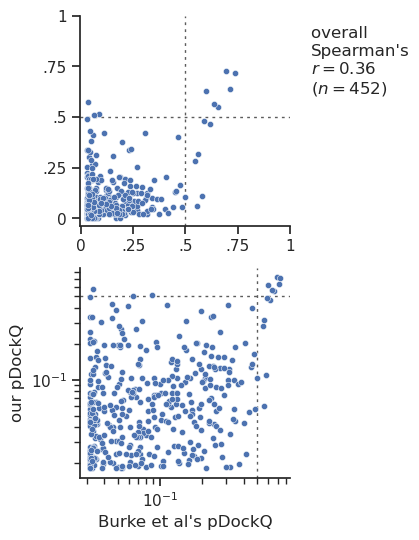

In [424]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))

for t, ax in enumerate(axes):
    st = sns.scatterplot(
        data=diffs,
        x='their_pdockq',
        y='our_pdockq',
        s=20,

        # height=3.2,
        # aspect=.8,
        ax=ax,
    )
    if t:
        ax.set(yscale='log', xscale='log', )
    xr = [0, .25, .5, .75, 1]
    xl = '0', '.25', '.5', '.75', '1'
    ax.set(box_aspect=1)
    if t:
        ax.set(xlabel='Burke et al\'s pDockQ', ylabel='our pDockQ')
    if not t:
        ax.set(xlabel=None, ylabel=None, xticklabels=xl, yticklabels=xl)
        ax.set(xticks=xr, yticks=xr)
    if not t:
        rho = spearmanr(diffs['their_pdockq'], diffs['our_pdockq'])
        ax.text(1.1, .95, f'overall \nSpearman\'s\n$r={rho[0]:.2f}$ \n($n={len(diffs)}$)', ha='left', va='top')
    kw = dict(dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=0)
    ax.axhline(y=.5, **kw)
    ax.axvline(x=.5, **kw)
sns.despine(fig)
fig.savefig('plots/pdock_us_vs_them_three.svg')
# whoopsie!

## HuRI / hu.MAP: histogram of disorder by CAPRI

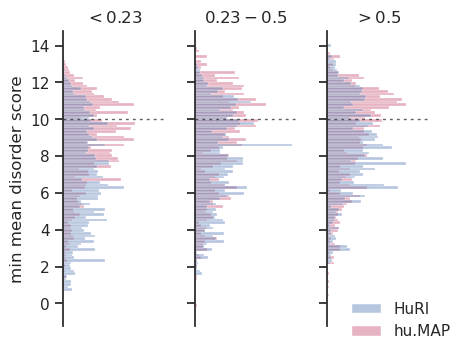

In [428]:
pal_r = {'HuRI': '#4c72b0', 'hu.MAP': '#c14168'}
mp = h4.loc[h4.dataset.isin(pal_r.keys())]

sn = sns.displot(
    data=mp,
    y='min_chezod',
    hue='dataset',
    col='capri', col_order=capris[:-1],
    palette=pal_r,
    bins=100,
    alpha=.4,
    stat='density', common_norm=False,
    height=4, aspect=.4,
    facet_kws=dict(margin_titles=True),
)

sn.set(yscale='linear', xlabel=None, xticks=[])
sn.despine(bottom=True)
sn.axes.flatten()[0].set(xlabel=None, ylabel='min mean disorder score')
sn.set_titles(col_template='{col_name}')
for ax, q in zip(sn.axes.flatten(), num_capris):
    ax.axhline(y=10, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
    # ax.text(0, 1, q, ha='center', va='bottom', transform=ax.transAxes)
    ax.set_title(q)
sns.move_legend(sn, loc='lower right', frameon=False,
                bbox_to_anchor=(.8, .1),
                title=None, ncol=1)
sn.savefig('plots/chezods_by_capri_and_dataset.pdf')
# this complements the final one well

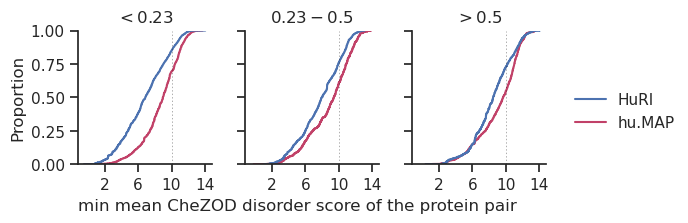

In [430]:
sn = sns.displot(
    data=mp,
    kind='ecdf',
    x='min_chezod',
    col='capri',
    col_order=capris[:-1],
    hue='dataset',
    palette=pal_r,

    height=2.4,
    aspect=.8,
)

sn.set(box_aspect=1, xticks=[2,6,10,14], xlabel=None)
sn.set_titles(col_template='{col_name}')

kw = dict(dashes=(2, 3), c='.1', lw=.5, alpha=.5, zorder=99)
for ax, t in zip(sn.axes[0, :], num_capris):
    ax.axvline(x=10, **kw)
    ax.set_title(t)
sn.legend.set_title(None)
sn.axes[0, 0].set_xlabel('min mean CheZOD disorder score of the protein pair', loc='left')
sn.savefig('plots/ecdf_humap_more_ordered.pdf')

## our data: histogram of disorder by CAPRI

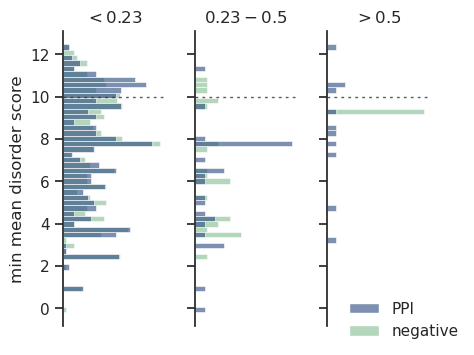

In [435]:
l, m, r = sns.color_palette('crest', 7)[0::3]
pal = [l, r]

ou = h4.loc[h4.dataset.isin(our_sets)].copy()
ou['label'] = ou.prob.apply(lambda p: 'PPI' if p else 'negative')

sn = sns.displot(
    data=ou,
    y='min_chezod',
    hue='label',
    col='capri', col_order=capris[:-1],
    palette=pal[::-1],
    # palette={'HuRI': '#4c72b0', 'hu.MAP': '#c14168'},
    bins=50,
    alpha=.6,
    stat='density', common_norm=False,
    height=4, aspect=.4,
    facet_kws=dict(margin_titles=True, sharex=False),
)
axes = sn.axes.flatten()

sn.set(yscale='linear', xlabel=None, xticks=[])
sn.despine(bottom=True)
axes[0].set(xlabel=None, ylabel='min mean disorder score')
sn.set_titles(col_template='{col_name}')
for ax, q in zip(sn.axes.flatten(), ['$< 0.23$', '$0.23 - 0.5$', '$> 0.5$']):
    ax.axhline(y=10, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
    # ax.text(0, 1, q, ha='center', va='bottom', transform=ax.transAxes)
    ax.set_title(q)
sns.move_legend(sn, loc='lower right', frameon=False,
                bbox_to_anchor=(.8, .1),
                title=None, ncol=1)

sn.savefig('plots/chezods_by_capri_ours.pdf')
# this complements the final one well

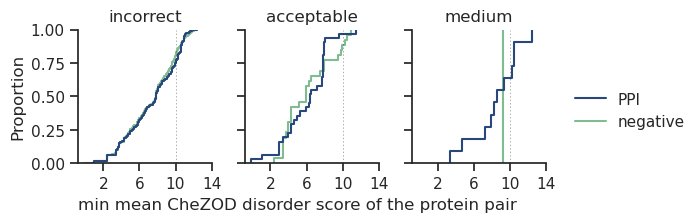

In [437]:
sn = sns.displot(
    data=ou,
    kind='ecdf',
    x='min_chezod',
    col='capri',
    col_order=capris[:-1],
    hue='label',
    palette=pal[::-1],
    # palette={'HuRI': '#4c72b0', 'hu.MAP': '#c14168'},

    height=2.4,
    aspect=.8,
)

sn.set(box_aspect=1, xticks=[2,6,10,14], xlabel=None)
sn.set_titles(col_template='{col_name}')

kw = dict(dashes=(2, 3), c='.1', lw=.5, alpha=.5, zorder=99)
for ax, t in zip(sn.axes[0, :], num_capris):
    ax.axvline(x=10, **kw)
    # ax.set_title(t)
sn.legend.set_title(None)
sn.axes[0, 0].set_xlabel('min mean CheZOD disorder score of the protein pair', loc='left')
sn.savefig('plots/ecdf_ours_more_ordered.pdf')
# medium has more steps than 1 -> therefore the class is larger

## two good ecdf plots

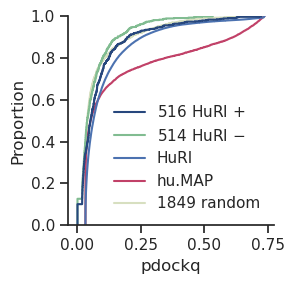

In [16]:
l, m, r = sns.color_palette('crest', 7)[0::3]
ran = sns.cubehelix_palette(4, start=.5, rot=-.75).as_hex()[0]
pal = [l, r]
pal_n = dict(zip(sorted(our_sets)[:2][::-1], pal[::-1])) | {'HuRI': '#4c72b0', 'hu.MAP': '#c14168'} | {'1849 random': ran}

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.ecdfplot(data=h4,
             x='pdockq',
             hue='dataset',
             hue_order=pal_n.keys(),
             palette=pal_n,
             ax=ax,
             )
sns.despine()
ax.get_legend().set_title(None)
fig.tight_layout()
fig.savefig('plots/ecdf_pdockq.pdf')
# hu.MAP gives the highest pDockQs

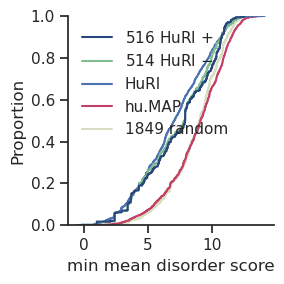

In [456]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.ecdfplot(data=h4,
             x='min_chezod',
             hue='dataset',
             hue_order=pal_n.keys(),
             palette=pal_n,
             ax=ax,
             )
ax.set(xlabel='min mean disorder score')
ax.get_legend().set_title(None)
sns.despine()
fig.tight_layout()
fig.savefig('plots/ecdf_chezod.pdf')
# hu.MAP and the set of random pairs are most ordered, HuRI is most disordered

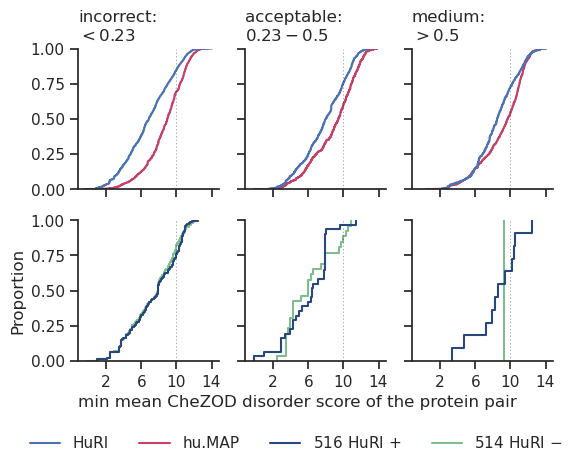

In [17]:
order = ['HuRI', 'hu.MAP'] + sorted(our_sets)[::-1]

h5 = h4.copy()
h5['row'] = h5.dataset.apply(lambda ds: 1 if ds in our_sets else 0)

sn = sns.displot(
    data=h5,
    kind='ecdf',
    x='min_chezod',
    hue='dataset',
    palette=pal_n,
    hue_order=order,
    col='capri',
    col_order=capris[:-1],
    row='row',

    height=2.4,
    aspect=.8,

)
sn.set(box_aspect=1, xticks=[2,6,10,14], xlabel=None)
sn.set_titles(template='')

kw = dict(dashes=(2, 3), c='.1', lw=.5, alpha=.5, zorder=99)
for j, ax in enumerate(sn.axes.flatten()):
    if not j:
        ax.set(ylabel=None)
    ax.axvline(x=10, **kw)
    if j < 3:
        ax.set_title(f'{capris[j]}:\n{num_capris[j]}', loc='left')
    else:
        ax.set(title=None)
sn.legend.set_title(None)
plt.subplots_adjust(hspace=-.15)
sn.axes[1, 0].set_xlabel('min mean CheZOD disorder score of the protein pair', loc='left')
sns.move_legend(sn, 'upper left', bbox_to_anchor=(.02, .08), title=None, ncol=5)
sn.savefig('plots/ecdf_capri_over_chezod.pdf')
# good predictions are more ordered

In [449]:
spearmanr(h4.pdockq, h4.min_chezod)

SignificanceResult(statistic=0.15348065859231155, pvalue=0.0)

In [450]:
len(h4)

68363

## great simplified scatters

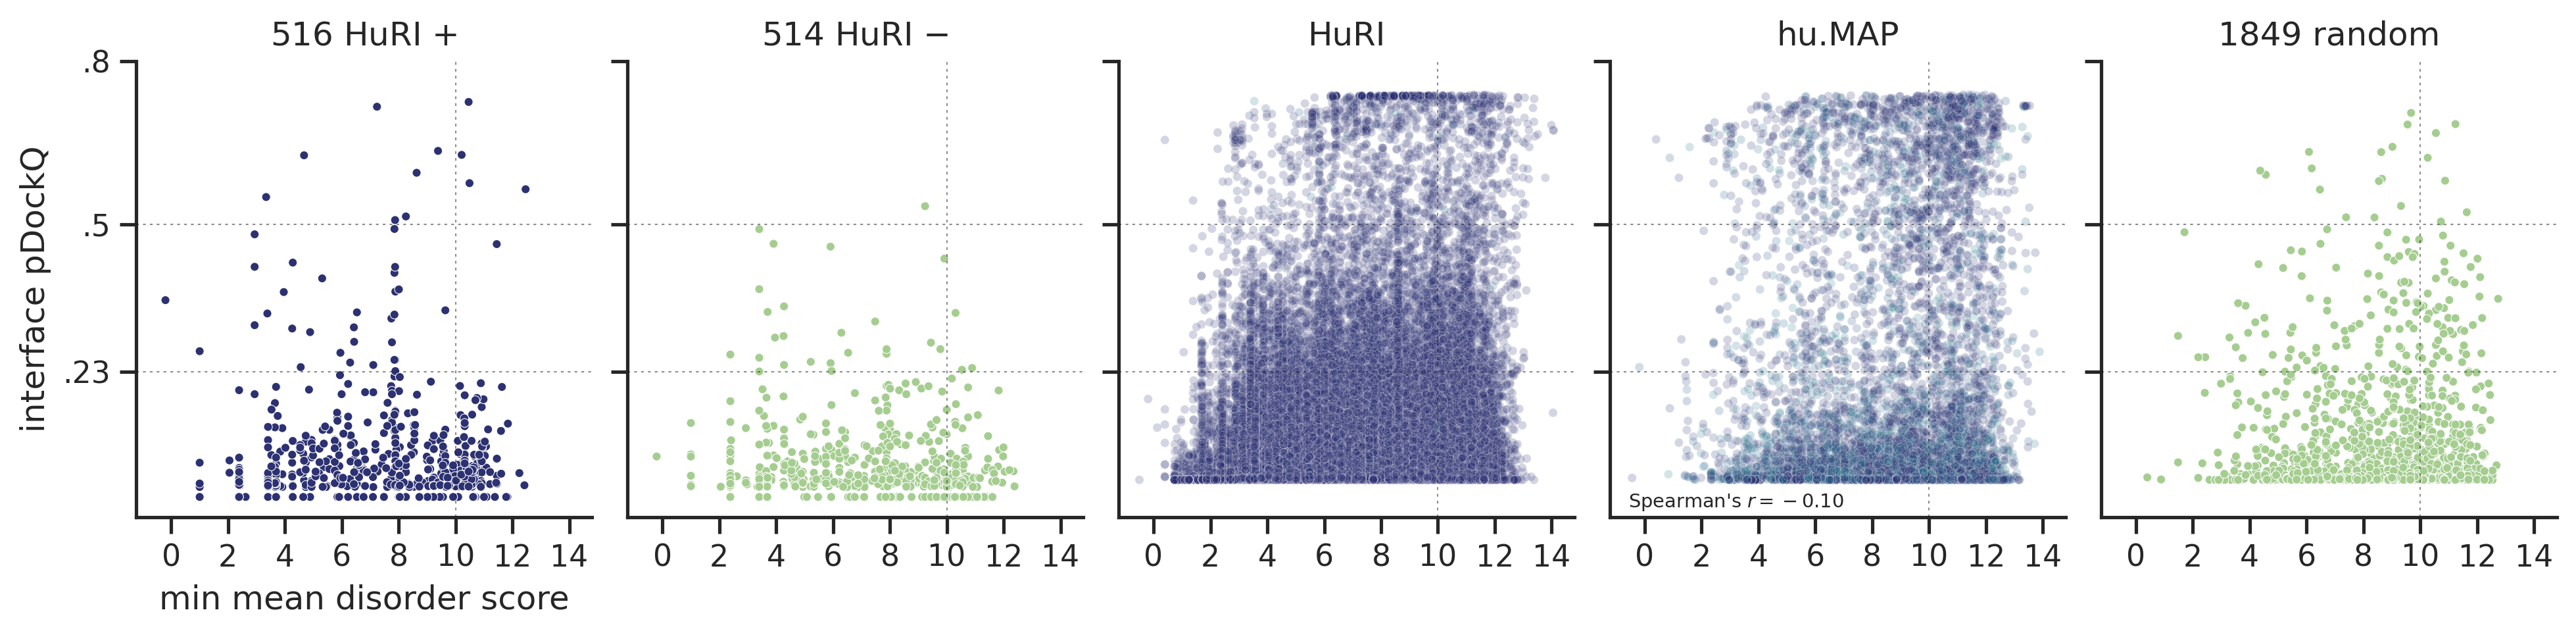

In [457]:
from matplotlib.ticker import MaxNLocator
sets = pal_n.keys()

fig, axes = plt.subplots(nrows=1, ncols=len(sets),
                         figsize=(3.2 * len(sets), 3),
                         sharex=True, sharey=True, dpi=300)
shrink = ['HuRI', 'hu.MAP']
for j, (_set, ax) in enumerate(zip(sets, axes)):
    df = h4.loc[h4.dataset == _set]
    sn = sns.scatterplot(
        data=df,
        y='pdockq',
        x='min_chezod',
        hue='prob', palette='crest', hue_norm=(0, 1),
        s=10,
        alpha=1 if _set not in shrink else .2,
        ax=ax,
        legend=False,
        rasterized=True,
    )
    ax.set(title=_set, yticks=[.23, .5, .8], yticklabels=['.23', '.5', '.8'], ylabel=None, xlabel=None, box_aspect=1)
    for l in [.23, .5]:
        kw = dict(dashes=(2, 3), c='.1', lw=.5, alpha=.5, zorder=99)
        ax.axhline(y=l, **kw)
    ax.axvline(x=10, **kw)
    # ax.axvline(x=.5, **kw)
    # ax.set(xlim=(1, 0))
    if not j:
        ax.set(xlabel='min mean disorder score', ylabel='interface pDockQ')
    if _set == 'hu.MAP':
        rho = spearmanr(df.pdockq, df.prob)[0]
        ax.text(.04, .01, f'Spearman\'s $r = {rho:.2f}$', ha='left', va='bottom', fontsize='xx-small', transform=ax.transAxes)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplots_adjust(wspace=.02)
sns.despine()
fig.savefig('plots/chezod_flipped.pdf', bbox_inches='tight')
# the most confident predictions are positives!

In [458]:
ours.loc[ours.capri == 'medium', 'prob'].value_counts()

1.0    11
0.0     1
Name: prob, dtype: int64

## investigate doubly-disordered pairs with high pdockqs

In [461]:
c1 = h4.loc[(h4.capri == 'medium') & (h4.pdockq > .6) & (
        h4.max_chezod < 6)].sort_values(
    by='max_chezod')[['ida', 'idb', 'dataset', 'pdbfile']].copy()
c1.loc[c1.dataset == 'hu.MAP', 'dataset'] = 'humap'
c1

,ida,idb,dataset,pdbfile
19695,P15408,P17275,humap,P15408-P17275.pdb
15357,P01100,P17275,humap,P01100-P17275.pdb
20449,P17275,P53539,humap,P53539-P17275.pdb
19968,P15884,Q92886,HuRI,ENSG00000181965-ENSG00000196628.pdb
1575,A6NI15,P15884,HuRI,ENSG00000151379-ENSG00000196628.pdb
...,...,...,...,...
58340,Q8WXI9,Q9UBB5,humap,Q8WXI9-Q9UBB5.pdb
53021,Q86YP4,Q9UBB5,HuRI,Q86YP4-Q9UBB5.pdb;ENSG00000134046-ENSG00000167...
29319,P50552,Q9UI08,humap,Q9UI08-P50552.pdb
67462,F8W6N5,Q8NBZ0,516 HuRI $+$,nope


In [465]:
def fetch(df: pd.DataFrame, folder: str = 'crop') -> None:
    f = Path(f'files_{folder}')
    with f.open('w') as txt:
        for idx, q in df.iterrows():
            for pdb in q.pdbfile.split(';'):
                pdb = Path(pdb)
                txt.write(f'{q.dataset}/{pdb.stem}/{pdb}\n')
                txt.write(f'{q.dataset}/{pdb.stem}/{pdb.with_suffix(".pLDDT")}\n')
                txt.write(f'{q.dataset}/{pdb.stem}/{pdb.with_suffix(".overlap")}\n')
    !rsync -i -zar --bwlimit=51200 --files-from $f -e ssh "kaindl@rostssh:/mnt/project/kaindl/huintaf2/" "/home/quirin/PYTHON/huintaf2/PDBs/$folder"
    f.unlink()

In [ ]:
fetch(c1, 'c1')

## look at the results in Mol*!

SETH makes us miss all the `JUN`-dimer family [P17275](https://www.uniprot.org/uniprotkb/P17275/entry)--[P53539](https://www.uniprot.org/uniprotkb/P53539/entry) interacting with transcriptional repressors

In [467]:
h4.loc[h4.pdbfile.str.contains('ENSG00000183733-ENSG00000196628')]

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
19938,P15884,Q6QHK4,0.654758,HuRI,ENSG00000183733-ENSG00000196628.pdb,1.0,CRC-53459FC7989D9487,CRC-82FBD792C3AEB035,2.87613,5.125292,0.856072,0.716895,2.87613,0.856072,5.125292,4.000711,medium


In [468]:
c2 = h4.loc[(h4.capri == 'medium') & (h4.pdockq > .72) & (h4.max_chezod >= 6) & (h4.max_chezod < 7)].sort_values(
    by='max_chezod')[['ida', 'idb', 'pdockq', 'max_chezod', 'dataset', 'pdbfile']].copy()
c2.loc[c2.dataset == 'hu.MAP', 'dataset'] = 'humap'
c2

,ida,idb,pdockq,max_chezod,dataset,pdbfile
45884,Q4VCS5,Q8IY63,0.731292,6.350918,humap,Q4VCS5-Q8IY63.pdb
22308,P25208,Q13952,0.722470,6.555009,HuRI,P25208-Q13952.pdb;ENSG00000066136-ENSG00000120...
41350,Q14188,Q16254,0.720716,6.588075,humap,Q16254-Q14188.pdb
41228,Q14134,Q14134,0.724029,6.614058,HuRI,ENSG00000137699-ENSG00000137699.pdb
58536,Q92539,Q9BQK8,0.723962,6.652146,humap,Q9BQK8-Q92539.pdb
41349,Q14188,Q15329,0.721231,6.698414,humap,Q15329-Q14188.pdb
9153,O60296,Q9UPV9,0.721851,6.701857,humap,Q9UPV9-O60296.pdb
54650,Q8N3L3,Q8N3L3,0.732473,6.872420,HuRI,ENSG00000164440-ENSG00000164440.pdb
45895,Q4VCS5,Q9Y2J4,0.730543,6.901636,HuRI,ENSG00000114019-ENSG00000126016.pdb
65400,Q9Y2J4,Q9Y2J4,0.735295,6.901636,HuRI,ENSG00000114019-ENSG00000114019.pdb


In [469]:
fetch(c2, 'c2')

rsync: link_stat "/mnt/project/kaindl/huintaf2/HuRI/P25208-Q13952/P25208-Q13952.pdb" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/HuRI/P25208-Q13952/P25208-Q13952.pLDDT" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/HuRI/P25208-Q13952/P25208-Q13952.overlap" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1861) [generator=3.2.7]


In [471]:
# great regular ones
c3 = h4.loc[(h4.capri == 'medium') & (h4.pdockq > .72) & (h4.min_chezod >= 13)].sort_values(
    by='pdockq', ascending=False)[[
    'ida', 'idb', 'dataset', 'pdbfile']].copy()
c3

,ida,idb,dataset,pdbfile
25421,P35609,P35609,HuRI,ENSG00000077522-ENSG00000077522.pdb
21534,P21673,P21673,HuRI,ENSG00000130066-ENSG00000130066.pdb


In [472]:
fetch(c3, 'c3')

In [473]:
# bad ones
c4 = h4.loc[(h4.capri == 'incorrect') & (h4.pdockq < .1) & (h4.min_chezod >= 13)].sort_values(
    by='pdockq')[['ida', 'idb', 'pdockq', 'min_chezod', 'dataset', 'pdbfile']].copy()
c4.loc[c4.dataset == 'hu.MAP', 'dataset'] = 'humap'
c4

,ida,idb,pdockq,min_chezod,dataset,pdbfile
19718,P15531,P61970,0.031322,13.376619,HuRI,ENSG00000102898-ENSG00000239672.pdb
34003,P62487,P62875,0.031322,13.144531,humap,P62487-P62875.pdb
33682,P62244,P63173,0.031343,13.144802,humap,P63173-P62244.pdb
21030,P19388,P62875,0.031514,13.189323,humap,P19388-P62875.pdb
31573,P60174,Q99497,0.036411,13.085114,humap,P60174-Q99497.pdb
32679,P60520,Q96FJ2,0.036798,13.122596,HuRI,ENSG00000034713-ENSG00000264364.pdb
17323,P09211,Q5TD97,0.037116,13.285077,HuRI,ENSG00000084207-ENSG00000112214.pdb
15623,P02689,P60174,0.044341,13.085114,humap,P02689-P60174.pdb
8269,O43708,Q01469,0.064980,13.005591,humap,Q01469-O43708.pdb
32657,P60520,P63167,0.070616,13.122596,HuRI,ENSG00000034713-ENSG00000088986.pdb


In [474]:
fetch(c4, 'c4')

In [478]:
# unknown ones
c5 = h4.loc[(h4.dataset == '1849 random') & (h4.capri == 'medium') & (h4.pdockq > .5) & (h4.min_chezod >= 8)].copy()
# c5.pdbfile = c5.apply(lambda row: f'{row.ida}-{row.idb}.pdb;{row.idb}-{row.ida}.pdb', axis=1)
c5.dataset = 'random'
c5.sort_values(by='pdockq', ascending=False)

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
66352,P61513,Q14974,0.704762,random,P61513-Q14974.pdb,0.0,CRC-7122AF87B0E24CF6,CRC-F3BB8B73E7E51639,9.674040,12.401224,0.293478,0.037671,9.674040,0.293478,12.401224,11.037632,medium
66574,P62888,Q14974,0.684326,random,P62888-Q14974.pdb,0.0,CRC-95186B081E39748C,CRC-F3BB8B73E7E51639,11.233173,12.401224,0.182609,0.037671,11.233173,0.182609,12.401224,11.817199,medium
66233,P55884,Q14974,0.683451,random,P55884-Q14974.pdb,0.0,CRC-C687A986EDAE0F5E,CRC-F3BB8B73E7E51639,9.549946,12.401224,0.277641,0.037671,9.549946,0.277641,12.401224,10.975585,medium
65589,P01889,Q15435,0.667872,random,P01889-Q15435.pdb,0.0,CRC-5E5A7BDE031403D6,CRC-49BCCF675EAA94D1,10.545604,11.203173,0.154696,0.191667,10.545604,0.191667,11.203173,10.874389,medium
66898,Q12959,P33176,0.642576,random,Q12959-P33176.pdb,0.0,CRC-6722993A84D0F761,CRC-A1FE5760C3250C8B,9.016979,10.752935,0.311947,0.170301,9.016979,0.311947,10.752935,9.884957,medium
65569,O75821,Q8N4P2,0.632841,random,O75821-Q8N4P2.pdb,0.0,CRC-7D7226FEDE9D6FBB,CRC-EE0C5DE820CFB84D,8.622864,12.083795,0.453125,0.105263,8.622864,0.453125,12.083795,10.353330,medium
65619,P10321,Q86X76,0.622515,random,P10321-Q86X76.pdb,0.0,CRC-59C23D95FD1D0BC8,CRC-90F7FB9D4BA627B1,10.259598,11.148466,0.183060,0.207951,10.259598,0.207951,11.148466,10.704032,medium
66043,P43631,O43660,0.583956,random,P43631-O43660.pdb,0.0,CRC-186C77DD9E86BA28,CRC-8C914CAF5F7887BD,9.025655,8.648374,0.305921,0.377432,8.648374,0.377432,9.025655,8.837015,medium
67233,Q9UMW8,P34059,0.580453,random,Q9UMW8-P34059.pdb,0.0,CRC-60248E8D4CC42BF0,CRC-1D086E528AAAE949,11.812588,10.869230,0.153226,0.155172,10.869230,0.155172,11.812588,11.340909,medium
66260,P61160,Q8WUA7,0.579710,random,P61160-Q8WUA7.pdb,0.0,CRC-1BFA6B442ED1A797,CRC-865A3CDCDA0C5543,12.179370,8.543052,0.058376,0.375242,8.543052,0.375242,12.179370,10.361211,medium


In [ ]:
fetch(c5, 'c5')

In [480]:
# disordered ones
c6 = h4.loc[(h4.min_chezod < .5)].sort_values(
    by='pdockq', ascending=False)[[
    'ida', 'idb', 'pdockq', 'min_chezod', 'max_chezod', 'dataset', 'pdbfile']].copy()
c6.loc[c6.dataset == 'hu.MAP', 'dataset'] = 'humap'
c6

,ida,idb,pdockq,min_chezod,max_chezod,dataset,pdbfile
3486,O00401,O43516,0.656197,0.399114,5.832225,humap,O43516-O00401.pdb;ENSG00000106299-ENSG00000115...
7608,O43516,P42768,0.655158,0.399114,5.688428,HuRI,ENSG00000015285-ENSG00000115935.pdb
67600,O14595,Q99618,0.361126,-0.199293,9.644398,516 HuRI $+$,nope
6013,O15194,Q99618,0.238327,-0.191315,9.317783,humap,O15194-Q99618.pdb
39006,Q12933,Q99618,0.179749,-0.191315,11.825663,HuRI,ENSG00000111665-ENSG00000127191.pdb
3414,O00308,O43516,0.160690,0.399114,10.082986,HuRI,ENSG00000115935-ENSG00000198373.pdb
7609,O43516,P53992,0.132872,0.399114,8.470179,HuRI,ENSG00000115935-ENSG00000176986.pdb
16297,P06454,Q14145,0.127252,0.129530,11.859620,HuRI,ENSG00000079999-ENSG00000187514.pdb
7612,O43516,Q9NYB9,0.099175,0.399114,5.487179,HuRI,ENSG00000115935-ENSG00000138443.pdb
68142,Q15014,Q99618,0.074239,-0.199293,8.009089,514 HuRI $-$,nope


In [481]:
fetch(c6, 'c6')

rsync: link_stat "/mnt/project/kaindl/huintaf2/humap/ENSG00000106299-ENSG00000115935/ENSG00000106299-ENSG00000115935.pdb" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/humap/ENSG00000106299-ENSG00000115935/ENSG00000106299-ENSG00000115935.pLDDT" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/humap/ENSG00000106299-ENSG00000115935/ENSG00000106299-ENSG00000115935.overlap" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/516 HuRI $+$/nope/nope" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/516 HuRI $+$/nope/nope.pLDDT" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/516 HuRI $+$/nope/nope.overlap" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/514 HuRI $-$/nope/nope" failed: No such file or directory (2)
rsync: link_stat "/mnt/project/kaindl/huintaf2/514 HuRI $-$/nope

In [482]:
# very disordered ones
h5 = h4.copy()
h5['avg_chezod'] = h5[['da', 'db']].mean(axis=1)
c7 = h5.loc[(h5.avg_chezod < 1)].copy()
c7 = c7.sort_values(by=['max_chezod', 'pdockq']).head(20)
c7

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
7771,O43561,Q96MG2,0.067920,HuRI,ENSG00000167476-ENSG00000213658.pdb,1.0,CRC-BCD80AE7DCA64153,CRC-BAB121BBB38EFB31,1.686599,1.391040,0.885496,0.966767,1.391040,0.966767,1.686599,0.926132,incorrect
56219,Q8NDC0,Q8NDC0,0.031838,HuRI,ENSG00000168175-ENSG00000168175.pdb,1.0,CRC-8B03ADFE2581D5C5,CRC-8B03ADFE2581D5C5,1.716327,1.716327,0.979592,0.979592,1.716327,0.979592,1.716327,0.979592,incorrect
802,A1KXE4,Q5T6F2,0.032563,HuRI,ENSG00000137073-ENSG00000152102.pdb,1.0,CRC-27A0D0D74AB44A10,CRC-75E7DC542258F82E,1.787983,1.409777,1.000000,0.933870,1.409777,1.000000,1.787983,0.966935,incorrect
20400,P17096,Q01844,0.031421,HuRI,ENSG00000137309-ENSG00000182944.pdb,1.0,CRC-E9C4E3F2200914B8,CRC-0DA02CEE146720BB,-0.498010,1.798921,1.000000,0.812500,-0.498010,1.000000,1.798921,0.906250,incorrect
36323,Q01844,Q8NDC0,0.031503,HuRI,ENSG00000168175-ENSG00000182944.pdb,1.0,CRC-0DA02CEE146720BB,CRC-8B03ADFE2581D5C5,1.798921,1.716327,0.812500,0.979592,1.716327,0.979592,1.798921,0.896046,incorrect
44002,Q16633,Q7Z4W3,0.031762,HuRI,ENSG00000110777-ENSG00000244025.pdb,1.0,CRC-2C46F1796774D614,CRC-D32EC93228804388,1.904727,1.254930,0.992188,1.000000,1.254930,1.000000,1.904727,0.996094,incorrect
813,A1KXE4,Q96HA1,0.032326,HuRI,ENSG00000152102-ENSG00000196313.pdb,1.0,CRC-27A0D0D74AB44A10,CRC-EDBA86CA5D658F61,1.787983,1.913064,1.000000,0.927142,1.787983,1.000000,1.913064,0.963571,incorrect
2404,A8MUN0,Q5TA76,0.031322,HuRI,ENSG00000185962-ENSG00000241598.pdb,1.0,CRC-B61D8AD19B271562,CRC-5E53A9A5739ABA84,1.368455,1.966483,1.000000,0.910112,1.368455,1.000000,1.966483,0.955056,incorrect
47988,Q5TA76,Q9BYP8,0.031328,HuRI,ENSG00000185962-ENSG00000186860.pdb,1.0,CRC-5E53A9A5739ABA84,CRC-AA633F91BD800582,1.966483,1.873074,0.910112,1.000000,1.873074,1.000000,1.966483,0.955056,incorrect
47979,Q5TA76,Q701N4,0.031343,HuRI,ENSG00000185962-ENSG00000205867.pdb,1.0,CRC-5E53A9A5739ABA84,CRC-BFA74666188A185C,1.966483,1.746643,0.910112,1.000000,1.746643,1.000000,1.966483,0.955056,incorrect


In [483]:
fetch(c7, 'c7')

## plot as one small figure

In [487]:
import functools

In [489]:
def orientation_plot(kde: bool = False,
                     markers: dict[tuple[float, float], str] = None,
                     grid: bool = False):
    fig, ax = plt.subplots(nrows=1, ncols=1,
                           figsize=(1.6, 1.6), dpi=300)

    _l, _m, _r = sns.color_palette('crest', 7)[0::3]
    pal2 = {'516 HuRI $+$': _r, '514 HuRI $-$': _l, 'HuRI': _r, 'hu.MAP': _r, '1849 random': _l}

    l, m, r = sns.color_palette('crest', 7)[0::3]
    ran = sns.cubehelix_palette(4, start=.5, rot=-.75).as_hex()[0]
    pal = [l, r]
    pal3 = {'516 HuRI $+$': _r, '514 HuRI $-$': _l, 'HuRI': '#4c72b0', 'hu.MAP': '#c14168', '1849 random': ran}
    pal4 = {'HuRI': '#4c72b0', 'hu.MAP': '#c14168'}

    @functools.lru_cache()
    def inner():
        sn = sns.kdeplot(
            data=h4.loc[h4.dataset.isin(pal4.keys())],
            y='pdockq',
            x='max_chezod',
            hue='dataset', palette=pal4,
            ax=ax,
            legend=True,
            # rasterized=True,
            common_norm=True,
            cut=0,
            clip=((0, 14), (0, 1)),
            levels=[.01, .25, .5, .75, .99],
        )
        return sn

    if not kde:
        sn = sns.scatterplot(
            data=h4,
            y='pdockq',
            x='max_chezod',
            hue='prob', palette='crest', hue_norm=(0, 1),
            s=2,
            alpha=.1,
            ax=ax,
            legend=False,
            rasterized=True,
        )
    else:
        sn = inner()

    ax.set(yticks=[.23, .5, .8], yticklabels=['.23', '.5', '.8'], box_aspect=1, ylabel=None)
    ax.set_xlabel('max mean disorder', loc='right')  #, fontsize='small')
    if grid:
        for l in [.23, .5]:
            kw = dict(dashes=(2, 3), c='.1', lw=.5, alpha=.5, zorder=99)
            ax.axhline(y=l, **kw)
        ax.axvline(x=10, **kw)
    sns.despine()

    if kde:
        sns.move_legend(sn, 'upper center', bbox_to_anchor=(.4, -.4), title=None, ncol=2,
                        columnspacing=1, handlelength=1, handletextpad=.4, markerscale=.4)  #, fontsize='small')

    if markers is not None:
        if type(markers) == list:
            markers = {m: r'$\times$' for m in markers}
        assert type(markers) == dict
        for (x, y), mark in markers.items():
            try:
                ax.text(x, y, mark, ha='center', va='center', zorder=100)
            except:
                pass

    return fig, ax

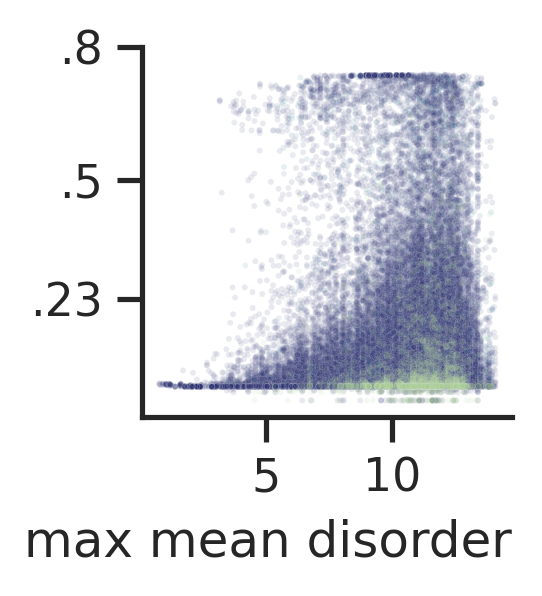

In [73]:
fig, ax = orientation_plot()
fig.savefig('plots/chezods_small.pdf', bbox_inches='tight')

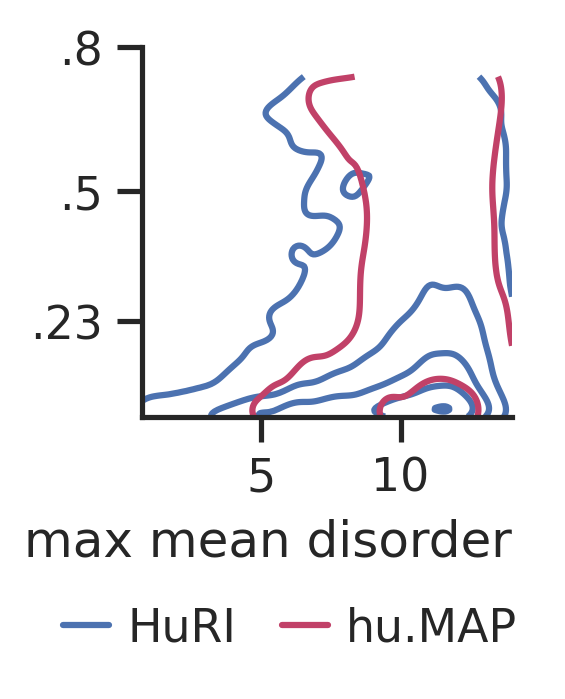

In [490]:
fig, ax = orientation_plot(kde=True)
fig.savefig('plots/chezods_small_kde.pdf', bbox_inches='tight')

## mark selected candidates

In [491]:
def go_fish(ida: str, idb: str):
    h3 = h4.loc[(h4.ida == ida) & (h4.idb == idb)]
    if not len(h3):
        h3 = h4.loc[(h4.ida == idb) & (h4.idb == ida)]
    if not len(h3):
        h3 = h4.loc[h4.pdbfile.str.contains(f'{ida}-{idb}')]
    if not len(h3):
        h3 = h4.loc[h4.pdbfile.str.contains(f'{idb}-{ida}')]
    h3 = h3.iloc[0, :]
    return h3.max_chezod, h3.pdockq

### c1

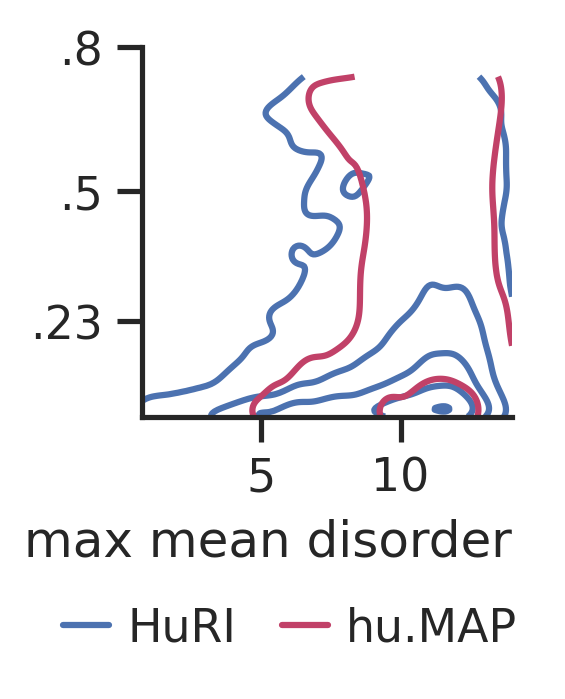

In [232]:
token = r'$\times$'
fig, ax = orientation_plot(kde=True)

In [493]:
# very high disorder, good pdockq
c1

,ida,idb,dataset,pdbfile
19695,P15408,P17275,humap,P15408-P17275.pdb
15357,P01100,P17275,humap,P01100-P17275.pdb
20449,P17275,P53539,humap,P53539-P17275.pdb
19968,P15884,Q92886,HuRI,ENSG00000181965-ENSG00000196628.pdb
1575,A6NI15,P15884,HuRI,ENSG00000151379-ENSG00000196628.pdb
...,...,...,...,...
58340,Q8WXI9,Q9UBB5,humap,Q8WXI9-Q9UBB5.pdb
53021,Q86YP4,Q9UBB5,HuRI,Q86YP4-Q9UBB5.pdb;ENSG00000134046-ENSG00000167...
29319,P50552,Q9UI08,humap,Q9UI08-P50552.pdb
67462,F8W6N5,Q8NBZ0,516 HuRI $+$,nope


In [494]:
x, y = go_fish('P17275', 'P53539')
x, y

(3.1440945935867703, 0.68028953)

In [495]:
ax.text(x, y, 'a', ha='center', va='center', zorder=100)

Text(3.1440945935867703, 0.68028953, 'a')

In [496]:
x, y = go_fish('Q9Y3Q8', 'Q15714')
x, y

(4.412754570683346, 0.61122016)

In [497]:
ax.text(x, y, 'b', ha='center', va='center', zorder=100)

Text(4.412754570683346, 0.61122016, 'b')

In [498]:
x, y = go_fish('ENSG00000146618', 'ENSG00000151379')
x, y

(5.626582134200866, 0.60867391)

In [499]:
ax.text(x, y, 'c', ha='center', va='center', zorder=100)

Text(5.626582134200866, 0.60867391, 'c')

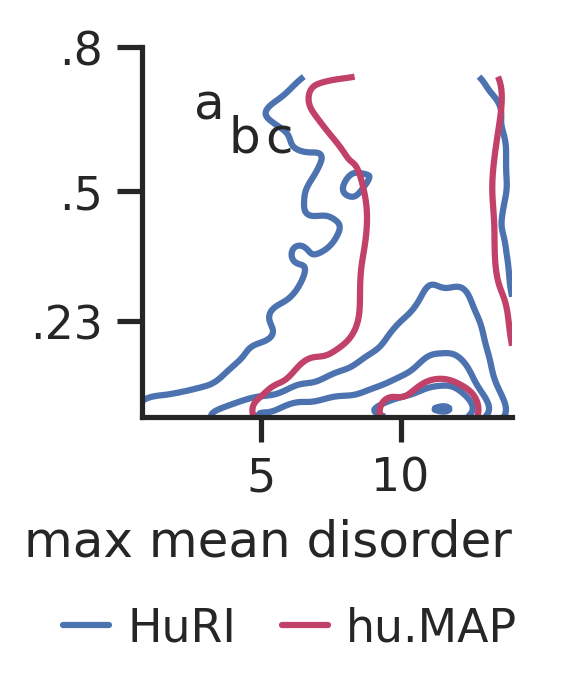

In [500]:
fig

In [501]:
fig.savefig('plots/overview_c1.pdf', bbox_inches='tight')

### c2

In [502]:
# token = r'$\times$'
# fig, ax = orientation_plot(kde=True)

In [503]:
# best pdockqs while still high disorder share chezod 6-7
c2

,ida,idb,pdockq,max_chezod,dataset,pdbfile
45884,Q4VCS5,Q8IY63,0.731292,6.350918,humap,Q4VCS5-Q8IY63.pdb
22308,P25208,Q13952,0.722470,6.555009,HuRI,P25208-Q13952.pdb;ENSG00000066136-ENSG00000120...
41350,Q14188,Q16254,0.720716,6.588075,humap,Q16254-Q14188.pdb
41228,Q14134,Q14134,0.724029,6.614058,HuRI,ENSG00000137699-ENSG00000137699.pdb
58536,Q92539,Q9BQK8,0.723962,6.652146,humap,Q9BQK8-Q92539.pdb
41349,Q14188,Q15329,0.721231,6.698414,humap,Q15329-Q14188.pdb
9153,O60296,Q9UPV9,0.721851,6.701857,humap,Q9UPV9-O60296.pdb
54650,Q8N3L3,Q8N3L3,0.732473,6.872420,HuRI,ENSG00000164440-ENSG00000164440.pdb
45895,Q4VCS5,Q9Y2J4,0.730543,6.901636,HuRI,ENSG00000114019-ENSG00000126016.pdb
65400,Q9Y2J4,Q9Y2J4,0.735295,6.901636,HuRI,ENSG00000114019-ENSG00000114019.pdb


In [504]:
x, y = go_fish('Q4VCS5', 'Q8IY63')
x, y

(6.350917605016504, 0.73129169)

In [505]:
ax.text(x, y, 'd', ha='center', va='center', zorder=100)

Text(6.350917605016504, 0.73129169, 'd')

In [506]:
x, y = go_fish('Q15329', 'Q14188')
x, y

(6.698414356033237, 0.72123116)

In [507]:
# # is identical, don't plot
# ax.text(x, y, '_d', ha='center', va='center', zorder=100)

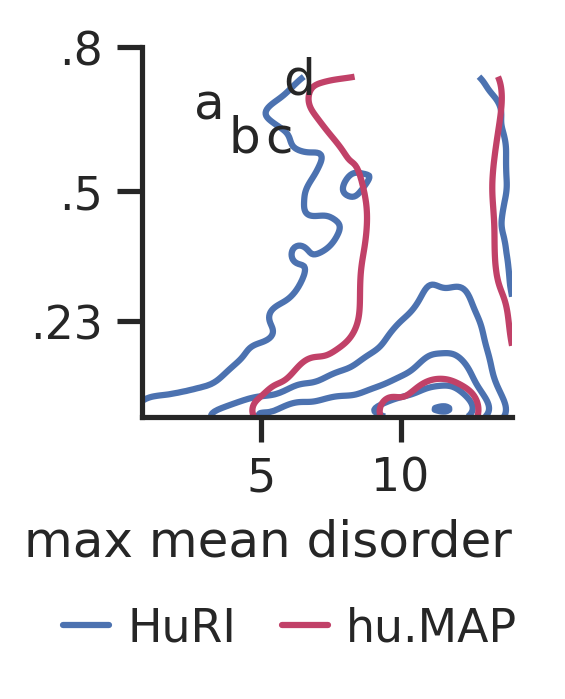

In [508]:
fig.savefig('plots/overview_c12.pdf', bbox_inches='tight')
fig
# don't save, plot some more

### c3

In [509]:
# great regular ones
c3

,ida,idb,dataset,pdbfile
25421,P35609,P35609,HuRI,ENSG00000077522-ENSG00000077522.pdb
21534,P21673,P21673,HuRI,ENSG00000130066-ENSG00000130066.pdb


In [510]:
x, y = go_fish('P35609', 'P35609')
x, y

(13.05314619162472, 0.73278859)

In [511]:
ax.text(x, y, 'e', ha='center', va='center', zorder=100)

Text(13.05314619162472, 0.73278859, 'e')

In [512]:
x, y = go_fish('P21673', 'P21673')
x, y

(13.384662828947368, 0.73056329)

In [513]:
# # is identical, don't plot
# ax.text(x, y, '_e', ha='center', va='center', zorder=100)

In [514]:
fig.savefig('plots/overview_c123.pdf', bbox_inches='tight')

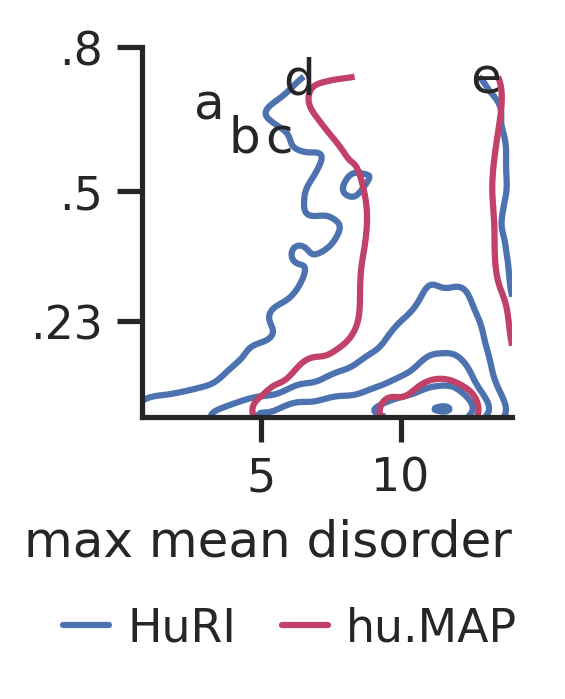

In [515]:
fig

### c4

In [516]:
# very bad but very ordered
c4

,ida,idb,pdockq,min_chezod,dataset,pdbfile
19718,P15531,P61970,0.031322,13.376619,HuRI,ENSG00000102898-ENSG00000239672.pdb
34003,P62487,P62875,0.031322,13.144531,humap,P62487-P62875.pdb
33682,P62244,P63173,0.031343,13.144802,humap,P63173-P62244.pdb
21030,P19388,P62875,0.031514,13.189323,humap,P19388-P62875.pdb
31573,P60174,Q99497,0.036411,13.085114,humap,P60174-Q99497.pdb
32679,P60520,Q96FJ2,0.036798,13.122596,HuRI,ENSG00000034713-ENSG00000264364.pdb
17323,P09211,Q5TD97,0.037116,13.285077,HuRI,ENSG00000084207-ENSG00000112214.pdb
15623,P02689,P60174,0.044341,13.085114,humap,P02689-P60174.pdb
8269,O43708,Q01469,0.064980,13.005591,humap,Q01469-O43708.pdb
32657,P60520,P63167,0.070616,13.122596,HuRI,ENSG00000034713-ENSG00000088986.pdb


In [517]:
x, y = go_fish('ENSG00000084207', 'ENSG00000112214')
x, y

(13.30264136904762, 0.03711557)

In [518]:
ax.text(x, y, 'f', ha='center', va='center', zorder=100)

Text(13.30264136904762, 0.03711557, 'f')

In [519]:
x, y = go_fish('ENSG00000034713', 'ENSG00000264364')
x, y

(13.44285463483146, 0.03679832)

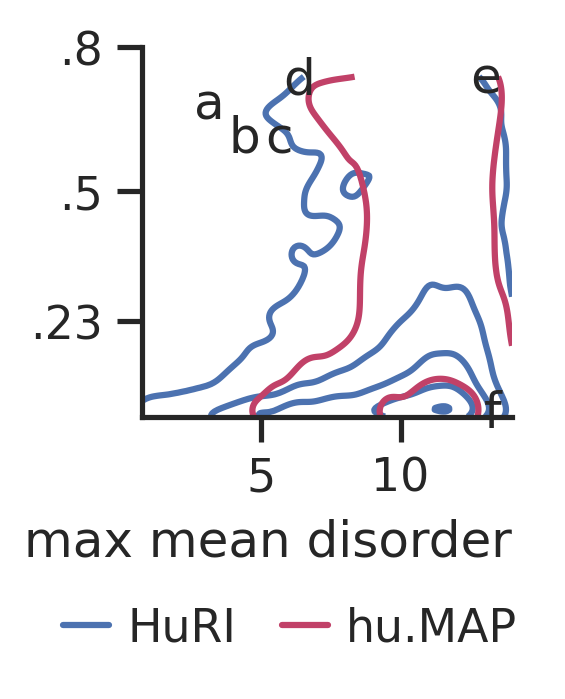

In [520]:
# # is identical, don't plot
# ax.text(x, y, '_f', ha='center', va='center', zorder=100)
fig.savefig('plots/overview_c1234.pdf', bbox_inches='tight')
fig

### c5

In [521]:
# unknown ones
c5

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
65569,O75821,Q8N4P2,0.632841,random,O75821-Q8N4P2.pdb,0.0,CRC-7D7226FEDE9D6FBB,CRC-EE0C5DE820CFB84D,8.622864,12.083795,0.453125,0.105263,8.622864,0.453125,12.083795,10.353330,medium
65589,P01889,Q15435,0.667872,random,P01889-Q15435.pdb,0.0,CRC-5E5A7BDE031403D6,CRC-49BCCF675EAA94D1,10.545604,11.203173,0.154696,0.191667,10.545604,0.191667,11.203173,10.874389,medium
65619,P10321,Q86X76,0.622515,random,P10321-Q86X76.pdb,0.0,CRC-59C23D95FD1D0BC8,CRC-90F7FB9D4BA627B1,10.259598,11.148466,0.183060,0.207951,10.259598,0.207951,11.148466,10.704032,medium
65701,P20853,P08579,0.505463,random,P20853-P08579.pdb,0.0,CRC-4DA10D0C2714E6AA,CRC-67C949CC7E14A92A,11.690623,10.721764,0.097166,0.231111,10.721764,0.231111,11.690623,11.206193,medium
65730,P25786,P36873,0.522509,random,P25786-P36873.pdb,0.0,CRC-3F159C5BCEFE8DED,CRC-0EEEF0E842188536,11.631335,11.883000,0.110266,0.089783,11.631335,0.110266,11.883000,11.757168,medium
66043,P43631,O43660,0.583956,random,P43631-O43660.pdb,0.0,CRC-186C77DD9E86BA28,CRC-8C914CAF5F7887BD,9.025655,8.648374,0.305921,0.377432,8.648374,0.377432,9.025655,8.837015,medium
66233,P55884,Q14974,0.683451,random,P55884-Q14974.pdb,0.0,CRC-C687A986EDAE0F5E,CRC-F3BB8B73E7E51639,9.549946,12.401224,0.277641,0.037671,9.549946,0.277641,12.401224,10.975585,medium
66260,P61160,Q8WUA7,0.579710,random,P61160-Q8WUA7.pdb,0.0,CRC-1BFA6B442ED1A797,CRC-865A3CDCDA0C5543,12.179370,8.543052,0.058376,0.375242,8.543052,0.375242,12.179370,10.361211,medium
66352,P61513,Q14974,0.704762,random,P61513-Q14974.pdb,0.0,CRC-7122AF87B0E24CF6,CRC-F3BB8B73E7E51639,9.674040,12.401224,0.293478,0.037671,9.674040,0.293478,12.401224,11.037632,medium
66564,P62888,O15194,0.534134,random,P62888-O15194.pdb,0.0,CRC-95186B081E39748C,CRC-5C7B32A1127B0F59,11.233173,9.317783,0.182609,0.336957,9.317783,0.336957,11.233173,10.275478,medium


In [522]:
x, y = go_fish('P01889', 'Q15435')
x, y

(11.2031734890408, 0.667872)

In [523]:
ax.text(x, y, 'g', ha='center', va='center', zorder=100)

Text(11.2031734890408, 0.667872, 'g')

In [524]:
x, y = go_fish('P61513', 'Q14974')
x, y

(12.401224493436072, 0.704762)

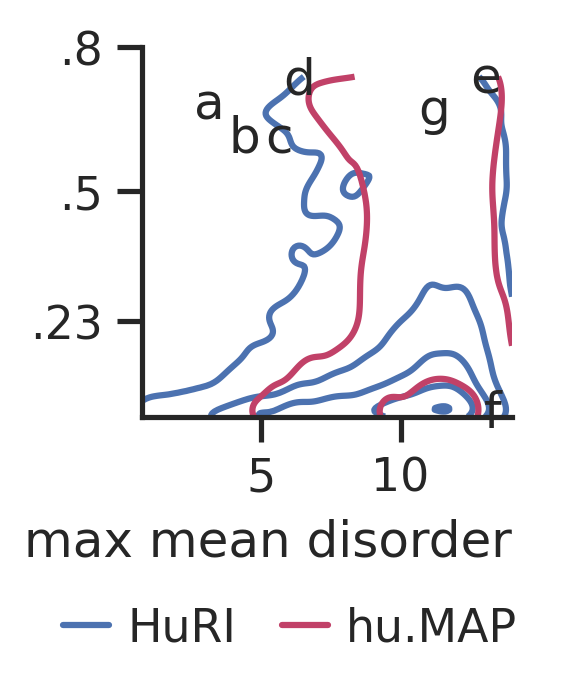

In [525]:
# # is identical, don't plot
# ax.text(x, y, '_G', ha='center', va='center', zorder=100)
fig

In [526]:
fig.savefig('plots/overview_c12345.pdf', bbox_inches='tight')

### c6

In [527]:
# pairs with one partner among the most disordered proteins
c6

,ida,idb,pdockq,min_chezod,max_chezod,dataset,pdbfile
3486,O00401,O43516,0.656197,0.399114,5.832225,humap,O43516-O00401.pdb;ENSG00000106299-ENSG00000115...
7608,O43516,P42768,0.655158,0.399114,5.688428,HuRI,ENSG00000015285-ENSG00000115935.pdb
67600,O14595,Q99618,0.361126,-0.199293,9.644398,516 HuRI $+$,nope
6013,O15194,Q99618,0.238327,-0.191315,9.317783,humap,O15194-Q99618.pdb
39006,Q12933,Q99618,0.179749,-0.191315,11.825663,HuRI,ENSG00000111665-ENSG00000127191.pdb
3414,O00308,O43516,0.160690,0.399114,10.082986,HuRI,ENSG00000115935-ENSG00000198373.pdb
7609,O43516,P53992,0.132872,0.399114,8.470179,HuRI,ENSG00000115935-ENSG00000176986.pdb
16297,P06454,Q14145,0.127252,0.129530,11.859620,HuRI,ENSG00000079999-ENSG00000187514.pdb
7612,O43516,Q9NYB9,0.099175,0.399114,5.487179,HuRI,ENSG00000115935-ENSG00000138443.pdb
68142,Q15014,Q99618,0.074239,-0.199293,8.009089,514 HuRI $-$,nope


In [528]:
x, y = go_fish('O43516', 'O00401')
x, y

(5.832225353883045, 0.6561968)

In [529]:
ax.text(x, y, 'h', ha='center', va='center', zorder=100)

Text(5.832225353883045, 0.6561968, 'h')

In [530]:
x, y = go_fish('ENSG00000015285', 'ENSG00000115935')
x, y

(5.688427746533398, 0.65515774)

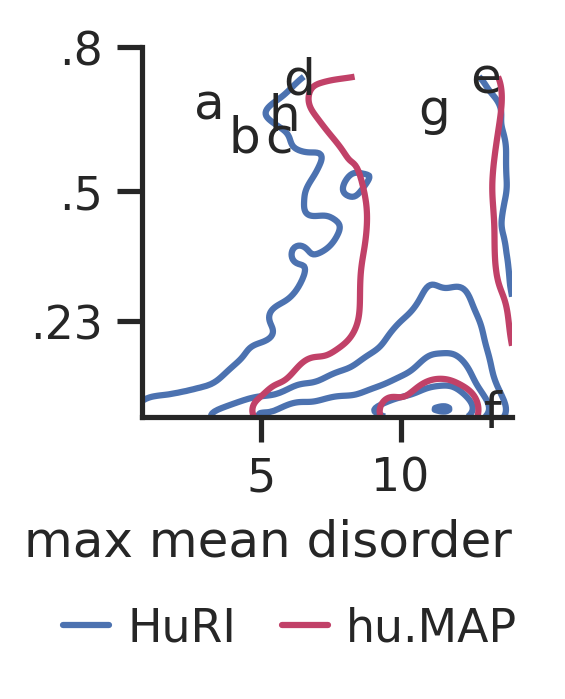

In [531]:
# # is identical, don't plot
# ax.text(x, y, '_h', ha='center', va='center', zorder=100)
fig.savefig('plots/overview_c1-6.pdf', bbox_inches='tight')
fig

### c7

In [532]:
#
c7

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
7771,O43561,Q96MG2,0.067920,HuRI,ENSG00000167476-ENSG00000213658.pdb,1.0,CRC-BCD80AE7DCA64153,CRC-BAB121BBB38EFB31,1.686599,1.391040,0.885496,0.966767,1.391040,0.966767,1.686599,0.926132,incorrect
56219,Q8NDC0,Q8NDC0,0.031838,HuRI,ENSG00000168175-ENSG00000168175.pdb,1.0,CRC-8B03ADFE2581D5C5,CRC-8B03ADFE2581D5C5,1.716327,1.716327,0.979592,0.979592,1.716327,0.979592,1.716327,0.979592,incorrect
802,A1KXE4,Q5T6F2,0.032563,HuRI,ENSG00000137073-ENSG00000152102.pdb,1.0,CRC-27A0D0D74AB44A10,CRC-75E7DC542258F82E,1.787983,1.409777,1.000000,0.933870,1.409777,1.000000,1.787983,0.966935,incorrect
20400,P17096,Q01844,0.031421,HuRI,ENSG00000137309-ENSG00000182944.pdb,1.0,CRC-E9C4E3F2200914B8,CRC-0DA02CEE146720BB,-0.498010,1.798921,1.000000,0.812500,-0.498010,1.000000,1.798921,0.906250,incorrect
36323,Q01844,Q8NDC0,0.031503,HuRI,ENSG00000168175-ENSG00000182944.pdb,1.0,CRC-0DA02CEE146720BB,CRC-8B03ADFE2581D5C5,1.798921,1.716327,0.812500,0.979592,1.716327,0.979592,1.798921,0.896046,incorrect
44002,Q16633,Q7Z4W3,0.031762,HuRI,ENSG00000110777-ENSG00000244025.pdb,1.0,CRC-2C46F1796774D614,CRC-D32EC93228804388,1.904727,1.254930,0.992188,1.000000,1.254930,1.000000,1.904727,0.996094,incorrect
813,A1KXE4,Q96HA1,0.032326,HuRI,ENSG00000152102-ENSG00000196313.pdb,1.0,CRC-27A0D0D74AB44A10,CRC-EDBA86CA5D658F61,1.787983,1.913064,1.000000,0.927142,1.787983,1.000000,1.913064,0.963571,incorrect
2404,A8MUN0,Q5TA76,0.031322,HuRI,ENSG00000185962-ENSG00000241598.pdb,1.0,CRC-B61D8AD19B271562,CRC-5E53A9A5739ABA84,1.368455,1.966483,1.000000,0.910112,1.368455,1.000000,1.966483,0.955056,incorrect
47988,Q5TA76,Q9BYP8,0.031328,HuRI,ENSG00000185962-ENSG00000186860.pdb,1.0,CRC-5E53A9A5739ABA84,CRC-AA633F91BD800582,1.966483,1.873074,0.910112,1.000000,1.873074,1.000000,1.966483,0.955056,incorrect
47979,Q5TA76,Q701N4,0.031343,HuRI,ENSG00000185962-ENSG00000205867.pdb,1.0,CRC-5E53A9A5739ABA84,CRC-BFA74666188A185C,1.966483,1.746643,0.910112,1.000000,1.746643,1.000000,1.966483,0.955056,incorrect


In [533]:
x, y = go_fish('ENSG00000137309', 'ENSG00000182944')
x, y

(1.798921492041611, 0.03142071)

In [534]:
ax.text(x, y, 'i', ha='center', va='center', zorder=100)

Text(1.798921492041611, 0.03142071, 'i')

In [535]:
x, y = go_fish('ENSG00000185962', 'ENSG00000187180')
x, y

(1.966483126865344, 0.03318388)

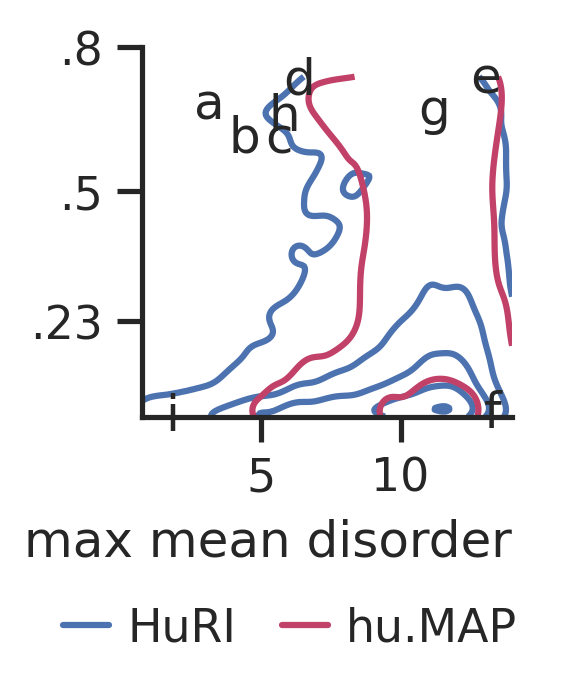

In [536]:
# # is identical, don't plot
# ax.text(x, y, '_h', ha='center', va='center', zorder=100)
fig

In [537]:
fig.savefig('plots/overview_c1-7.pdf', bbox_inches='tight')

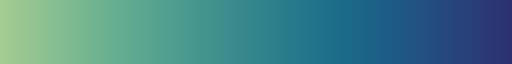

In [297]:
sns.color_palette('crest', as_cmap=True)

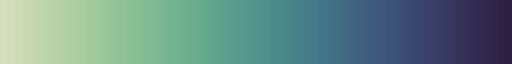

In [291]:
sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

In [126]:
sns.cubehelix_palette(4, start=.5, rot=-.75)

[[0.8423298817793848, 0.8737404427964184, 0.7524954030731037],
 [0.4576142801317438, 0.7057950454122253, 0.5634791991994519],
 [0.25744332683867743, 0.42368146872794976, 0.5191691971789513],
 [0.17250549177124488, 0.11951843162770594, 0.24320155229883056]]

In [127]:
sns.cubehelix_palette(4, start=.5, rot=-.75).as_hex()[0]

'#d7dfc0'

In [ ]:
l, m, r = sns.color_palette('crest', 7)[0::3]

In [119]:
sns.color_palette('crest', 7)

[(0.50711872, 0.73665492, 0.56821764),
 (0.37890483, 0.66859548, 0.56566462),
 (0.28251558, 0.59517119, 0.56181204),
 (0.20094292, 0.52087429, 0.55342884),
 (0.12709242, 0.44601517, 0.54438795),
 (0.11646936, 0.36578429, 0.52726234),
 (0.15138673, 0.27982444, 0.49119848)]

In [121]:
sns.color_palette(as_cmap=False)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [123]:
print(sns.color_palette(as_cmap=False).as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']
